What I want the data to look like 

8 mice
2 conditions
2 states per condition: sedentary and running
100 trials per condition


results are z-scores that range from -3.5 to 3.5 (using the same range as other paper) 

M1 activity primarily modulated by running onset. see similar increases in activity in both conditions. low activity in sendentary state
Amygdala: most units have higher firing activity during sendentary phase of stress condition compared to sedentary phase of spontaneous running. See big spike in activity at stimulus onset

VTA: relatively slow ramp up in activity preceding spontaneous running onset, whereas rapid spike at or after escape onset 
    - these might be different neuron populations 



want the firing rates to be modulated by my eight factors (i.e units would fall into one of those groups, and different regiosns would have different proportions of units within the groups) 





0.64 ± 0.32 neurons per recording site on average (Jun et al, 2018, https://pmc.ncbi.nlm.nih.gov/articles/PMC5955206/)
384 channels (aka sites to record from)
10 mm long probe
960 recording sites for 1.0
1250 recording sites for 2.0 probe per shank (steinmetz et al, 2021, https://www.science.org/doi/10.1126/science.abf4588)
2.0 4 shank spans 0.7 mm



dentate nucleus: 0.8 mm DV

amygdala: ~1.2mm AP, 0.9 mm DV  

M1: 1.3 mm ML, 0.4DV

Going through FF and VTA at an angle with the same probe would cover 2.55 mm. Just gonna say divide the units 50/50


assumptions to make 
- for simplicity, going to assume all regions have equal cell density (very much not true, especially in cortex)

using this atlas to estimate: https://scalablebrainatlas.incf.org/mouse/ABA_v3 

proportion that are paradigm modulated per region on average 
DN: 75% (of this, about 90% respond to running onset, and of that group 10% respond only in condition 1, and 60% respond in both conditions but respond more strongly to running onset in condition 1) 
M1: 60% (of this, 80% respond to running onset in both conditions, and 15% are responding only in condition 2) 
VTA: 70%
CeA: 70% 
FF: 50%



In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy import stats
from scipy.stats import sem
import matplotlib.cm as cm
from statsmodels.stats.multitest import multipletests


In [2]:
plt.rcParams['figure.dpi'] = 150  # Adjust this value as needed


# Calculate Number of units per animal per region

In [3]:
def sites_per_ROI (probe = 1, height = None, length = None):
    ''' calculate the number of recording sites per ROI based on the DV height, and width if using NPX probe 2.0 
    height: DV distance, 
    length: AP distance, diagonal, or ML distance'''
    if probe == 1:
        if height == None:
            return("provide height")
        density = 96 #units per mm 
        sites = height*density

    elif probe ==2:
        density = 125
        if length == None:
            return("provide length")
        elif length< 0.7:
            return("ROI length shorter than 4 shank span")
        sites = height*density*4 #because four shanks 
        if sites>384:
            sites = 384
    
    return(sites)
    

In [4]:
def dataframe_to_dict(df): #just a simple way to convert a dataframe to a dictionary
    return {col: df[col].tolist() for col in df.columns}

In [5]:
probe1_rois = {"DN":0.8, "FF":2.55/2, "VTA": 2.55/2} #dictionary with the regions and the amount of recording distance per region
probe2_rois = {"CeA":(0.9,1.2), "M1":(0.4, 1.3)}# dictionary with the regions and the amount of recording distance and width


In [6]:
rois = []
sites = []

probe = 1 
for roi in probe1_rois.keys():
    rois.append(roi)
    height = probe1_rois[roi]
    site_num = sites_per_ROI(probe,height)
    sites.append(round(site_num))

probe =2
for roi in probe2_rois.keys():
    rois.append(roi)
    height = probe2_rois[roi][0]
    length = probe2_rois[roi][1]
    site_num = sites_per_ROI(probe,height, length)
    sites.append(round(site_num))

sites_per_roi = dict(zip(rois,sites))
sites_per_roi

{'DN': 77, 'FF': 122, 'VTA': 122, 'CeA': 384, 'M1': 200}

In [7]:
#calculating how many single units I would get from each site based on the efficiency of the probes

single_units = []
animals = list(range(0,8))
for animal in animals: #simulating recording accross 8 animals
    np.random.seed(animal)#setting the seed for the random number generator so each time it is the same in this instance
    
    mean = 0.64 #number of neurons per recording site usually
    stdev = 0.32
    units = []
    
    units = np.random.normal(mean, stdev, 5) #generating a random number of neurons detected per site accross the five regions

    
    units_per_site = units*(np.array(sites))
    units_per_site = np.clip(units_per_site, 0, None)  # Values less than 0 will be clipped to 0

    single_units.append(units_per_site.round()) #rounding to whole numbers 

np.random.seed(seed = None) #unseeding things just in case 

In [8]:
rois_response_base = {"DN":0.75, "M1": 0.6, "VTA": 0.7, "CeA": 0.7, "FF":0.5}

In [9]:
#dataframe of the number of units per each region per animal
cprpaDF = pd.DataFrame(data = single_units, columns = rois)
cprpaDF = cprpaDF.round()
#cpr: units per region. Getting the total number of units per region
cpr= pd.DataFrame(cprpaDF.sum(), columns=["Counts"])

cpr

Counts
DN    558.0
FF    649.0
VTA   633.0
CeA  2076.0
M1    868.0

# Graphing Recorded units Per region distributions 

In [10]:

#making into long format for sns graphing
cprpaDF["Animal"] = range(1,9)
cprpaDF_long = cprpaDF.melt(id_vars="Animal", var_name="Region", value_name="Num units")


Text(0.5, 1.0, 'Single Units per Region by Animal')

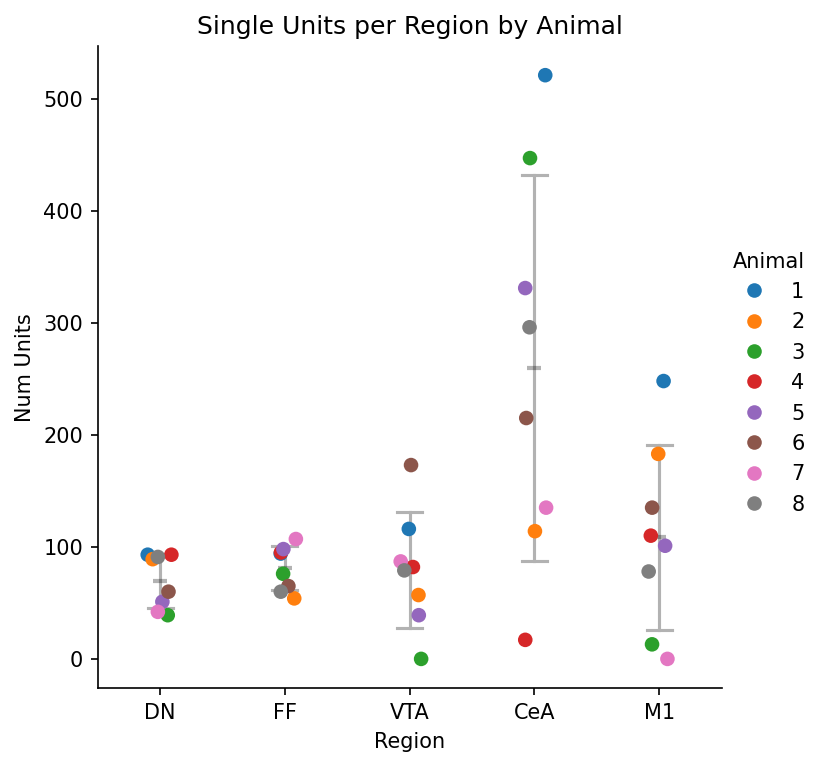

In [11]:
sns.catplot(data = cprpaDF_long, x = "Region", y= "Num units", hue= "Animal", palette="tab10", size = 7)


sns.pointplot(data=cprpaDF_long, x="Region", y="Num units", color='black', 
              errorbar='sd', markers = "_", capsize=0.2, err_kws={'linewidth': 1.5}, linestyle='none',alpha =0.3, legend=False)

plt.ylabel("Num Units")
plt.title("Single Units per Region by Animal")

#different distributions by region because the potential number of recording sites per region varies?
# the weird gap in the DN data is probably because I am limiting the outcome to whole numbers

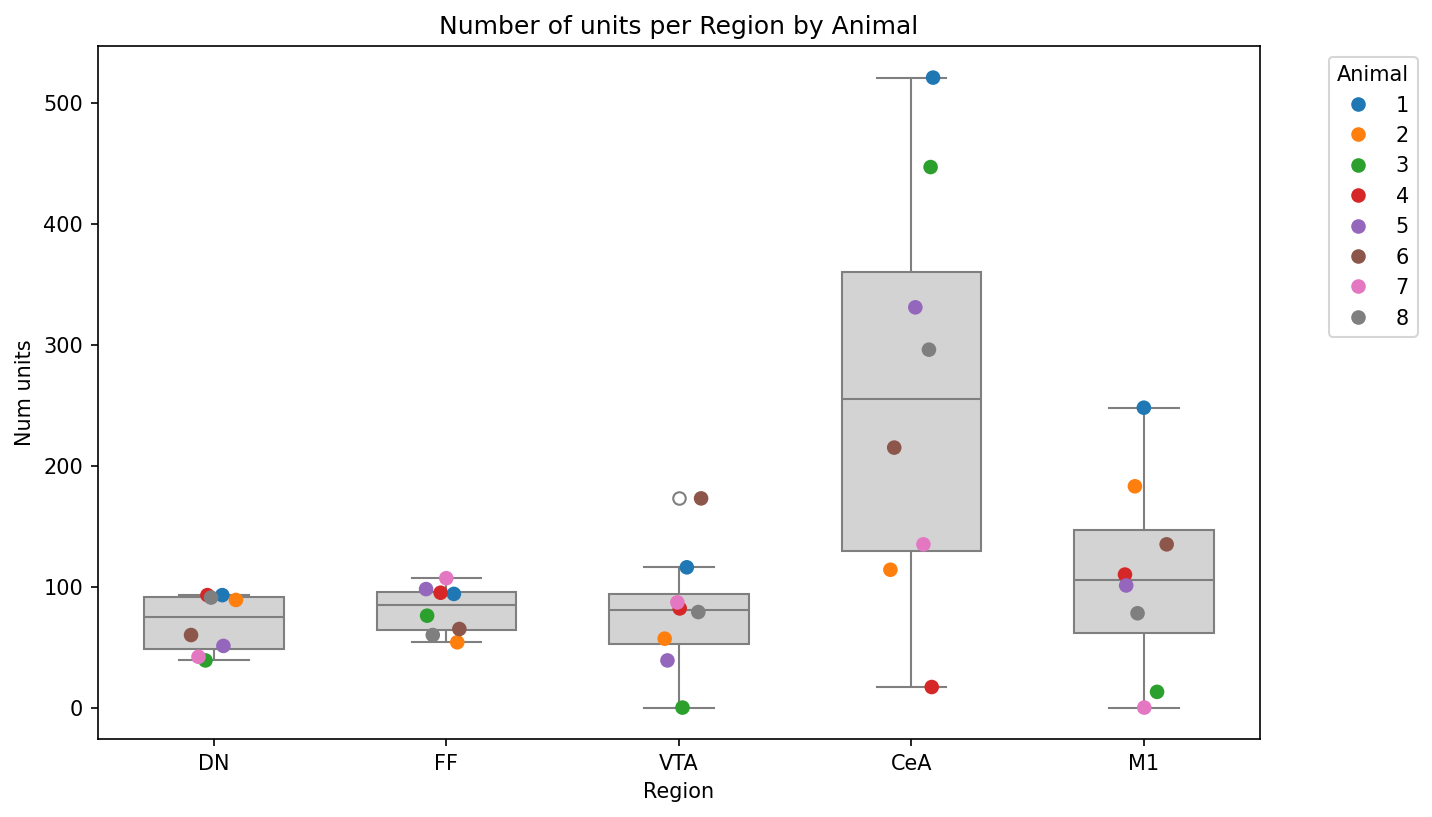

In [12]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=cprpaDF_long, x="Region", y="Num units", color="lightgrey", width=0.6)

# Overlay individual data points
sns.stripplot(data=cprpaDF_long, x="Region", y="Num units", hue="Animal", 
              palette="tab10", dodge=False, size=7)

plt.legend(title='Animal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Number of units per Region by Animal")
plt.show()

In [13]:
neuron_counts = dataframe_to_dict(cprpaDF.drop("Animal", axis=1))

In [14]:
neuron_counts

{'DN': [93.0, 89.0, 39.0, 93.0, 51.0, 60.0, 42.0, 91.0],
 'FF': [94.0, 54.0, 76.0, 95.0, 98.0, 65.0, 107.0, 60.0],
 'VTA': [116.0, 57.0, 0.0, 82.0, 39.0, 173.0, 87.0, 79.0],
 'CeA': [521.0, 114.0, 447.0, 17.0, 331.0, 215.0, 135.0, 296.0],
 'M1': [248.0, 183.0, 13.0, 110.0, 101.0, 135.0, 0.0, 78.0]}

In [15]:
pre_stim_points = 10
post_stim_points = 10
total_points = pre_stim_points + post_stim_points
z_score_range = (-3.5, 3.5)
#response_proportion = 0.7  # 70% of neurons respond
rois_response_base = {"DN":0.75, "M1": 0.6, "VTA": 0.7, "CeA": 0.7, "FF":0.5} #baseline how many neurons are task responsive

In [16]:
nested_list = list(neuron_counts.values())
flat_list = [item for sublist in nested_list for item in sublist]
sum(flat_list)

4784.0

In [40]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [43]:
(np.linspace(0, 1, 10)**4)*3

array([0.00000000e+00, 4.57247371e-04, 7.31595793e-03, 3.70370370e-02,
       1.17055327e-01, 2.85779607e-01, 5.92592593e-01, 1.09785094e+00,
       1.87288523e+00, 3.00000000e+00])

In [56]:
np.linspace(0, 3, 10)

array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ])

# Generate neuron data for each animal and region

In [196]:
def generate_neuron_activity(pre_stim, post_stim, num_units, mod_prop, max_variability_after_stimulus,trials=10, peak_variability=3 
                             ):
    """
    Generate neuron activity time series for multiple units, with modulated responses to a stimulus.
    
    pre_stim: number of points before stimulus
    post_stim: number of points after stimulus
    num_units: number of units to generate time series for 
    mod_prop: proportion of units that show change in activity in response to the stimulus
    trials: number of repetitions per cell for averaging
    peak_variability: the maximum variability (in time steps) for the peak around the stimulus time
    max_variability_after_stimulus: if True, variability is applied only within 1 time point after the stimulus
    """

    # Total points in the time series
    total_points = pre_stim + post_stim

    # Generate baseline activity (random z-scores) for all units across trials
    baseline_activity = np.random.uniform(-1, 0.5, (trials, num_units, total_points))

    # Number of modulated units
    mod_units = round(np.random.normal(mod_prop, .05) * num_units)

    # Ramp-up before stimulus and ramp-down after stimulus
    ramp_up = np.linspace(0, 3.5, pre_stim)
    ramp_down = np.linspace(2, 0, post_stim)
    ramp = np.concatenate((ramp_up, ramp_down))

    # Add variability to the peak time for modulated units
    for cell in range(mod_units):  # Loop over modulated units
        # Randomly choose an offset for the peak time around the stimulus point (pre_stim)
        peak_offset = np.random.randint(-peak_variability, peak_variability + 1)

        # Apply peak offset variability to the pre-stimulus ramp
        ramp_up_offset = np.linspace(0, 3, pre_stim + peak_offset)  # Adjust ramp-up with offset

        # Apply ramp-down after stimulus based on max_variability_after_stimulus flag
        if max_variability_after_stimulus:
            # If variability is only allowed until 1 time point after the stimulus:
            ramp_down_offset = np.linspace(2, 0, post_stim - peak_offset)  # Apply variability to ramp-down but limit to 1 after stimulus
            ramp_offset = np.concatenate((ramp_up_offset, ramp_down_offset[:2]))  # Only include 1 post-stimulus point
        else:
            ramp_down_offset = np.linspace(2, 0, post_stim - peak_offset)  # Apply variability to ramp-down
            ramp_offset = np.concatenate((ramp_up_offset, ramp_down_offset))

        # Ensure the ramp does not exceed the total length
        ramp_offset = ramp_offset[:total_points]  # Ensure it doesn't exceed the total length
        
        # If ramp_offset is shorter than expected, pad it with zeros to match the total length
        if len(ramp_offset) < total_points:
            ramp_offset = np.pad(ramp_offset, (0, total_points - len(ramp_offset)), 'constant', constant_values=0)
        
        # Add the modified ramp to the modulated units across all trials
        baseline_activity[:, cell] += ramp_offset

    # Calculate the mean time series across trials for each cell
    avg_neural_activity_all = baseline_activity.mean(axis=0)  # Shape: (num_units, total_points)
    avg_neural_activity_mod = avg_neural_activity_all[:mod_units] #also making it so can isolate just the modulated units
    #shuffling the order of the neurons
    np.random.shuffle(avg_neural_activity_all)

    
    return avg_neural_activity_all,avg_neural_activity_mod

In [197]:
generate_neuron_activity(pre_stim=10, post_stim= 10, num_units= 10, mod_prop=0.5, max_variability_after_stimulus= False)[0].shape

(10, 20)

In [225]:
# Generate neuron data for each animal and region

def roi_neuron_activity(rois_responseprop = rois_response_base, all_units = True, neuron_counts = neuron_counts, pre_stim = 10,
                        post_stim = 10, trials=10, peak_variability=5, max_variability_after_stimulus=True, seed = 0):
    ''' rois_responseprop: the proportion of units that are modulated by the task, by roi. this is a dictionary
        all_units: whether or not to include only units modulated by the task 
        rois_responseprop: proportion of units that increase ramp up pre-running onset (should be a dictionary based on roi as well) 
    '''
    all_neuron_data = []
    neuron_id_counter = 0  # Start a counter for unique neuron IDs

    np.random.seed(seed = seed) #setting a seed to hopefully get the same results every time this is run, but allowing for variation 
    
    for animal_id, (dn, ff, vta, cea, m1) in enumerate(zip(*neuron_counts.values())):
        for region, num_neurons in zip(["DN", "FF", "VTA", "CeA", "M1"], [dn, ff, vta, cea, m1]):
            # Generate time series for neurons in this region
            response_proportion = rois_responseprop[region]
            time_series_all, time_series_mod = generate_neuron_activity(pre_stim, 
                                                                        post_stim, 
                                                                        int(num_neurons),
                                                                        mod_prop=response_proportion, 
                                                                        max_variability_after_stimulus= max_variability_after_stimulus)
            
            # Calculate peak times for each neuron in the generated time series
            if all_units == True:
                time_series = time_series_all
            else:
                time_series = time_series_mod
           
            peak_times = get_peak_times(time_series)

            
            # Append each neuron’s data with region, time series, peak time, and unique neuron ID
            for neuron_series, peak_time in zip(time_series, peak_times):
                all_neuron_data.append((region, neuron_id_counter, neuron_series, peak_time))
                neuron_id_counter += 1  # Increment neuron ID for the next neuron
    
    return all_neuron_data


# Function to calculate the peak response time for each neuron
def get_peak_times(neural_activity_array):
    peak_times = []
    for array in neural_activity_array:
        np.array(peak_times.append(np.argmax(array))) 
    return peak_times

In [226]:
def smooth_time_series(time_series, sigma=1.0):
    # Apply Gaussian filter to smooth the time series
    return gaussian_filter1d(time_series, sigma=sigma)

In [227]:
def heatmap_conversion (data = roi_neuron_activity()):
    ''' converting the data into a format that can be graphed in a heatmap'''
    # Sort all neurons by region and peak response time
    data.sort(key=lambda x: (x[0], x[3]))  # Sort by region, then by peak_time
    
    # Prepare data for the heatmap
    sorted_time_series = []
    sorted_labels = []
    
    # Create a list of sorted time series and labels
    current_region = None
    for region, neuron_id, time_series, peak_time in data:
        # Only add a region label once for each group of neurons
        if region != current_region:
            sorted_labels.append(region)  # Append the region label
            current_region = region
        
        sorted_time_series.append(time_series)
    
    # Convert list to a NumPy array for heatmap
    heatmap_data = np.array(sorted_time_series)
    return heatmap_data


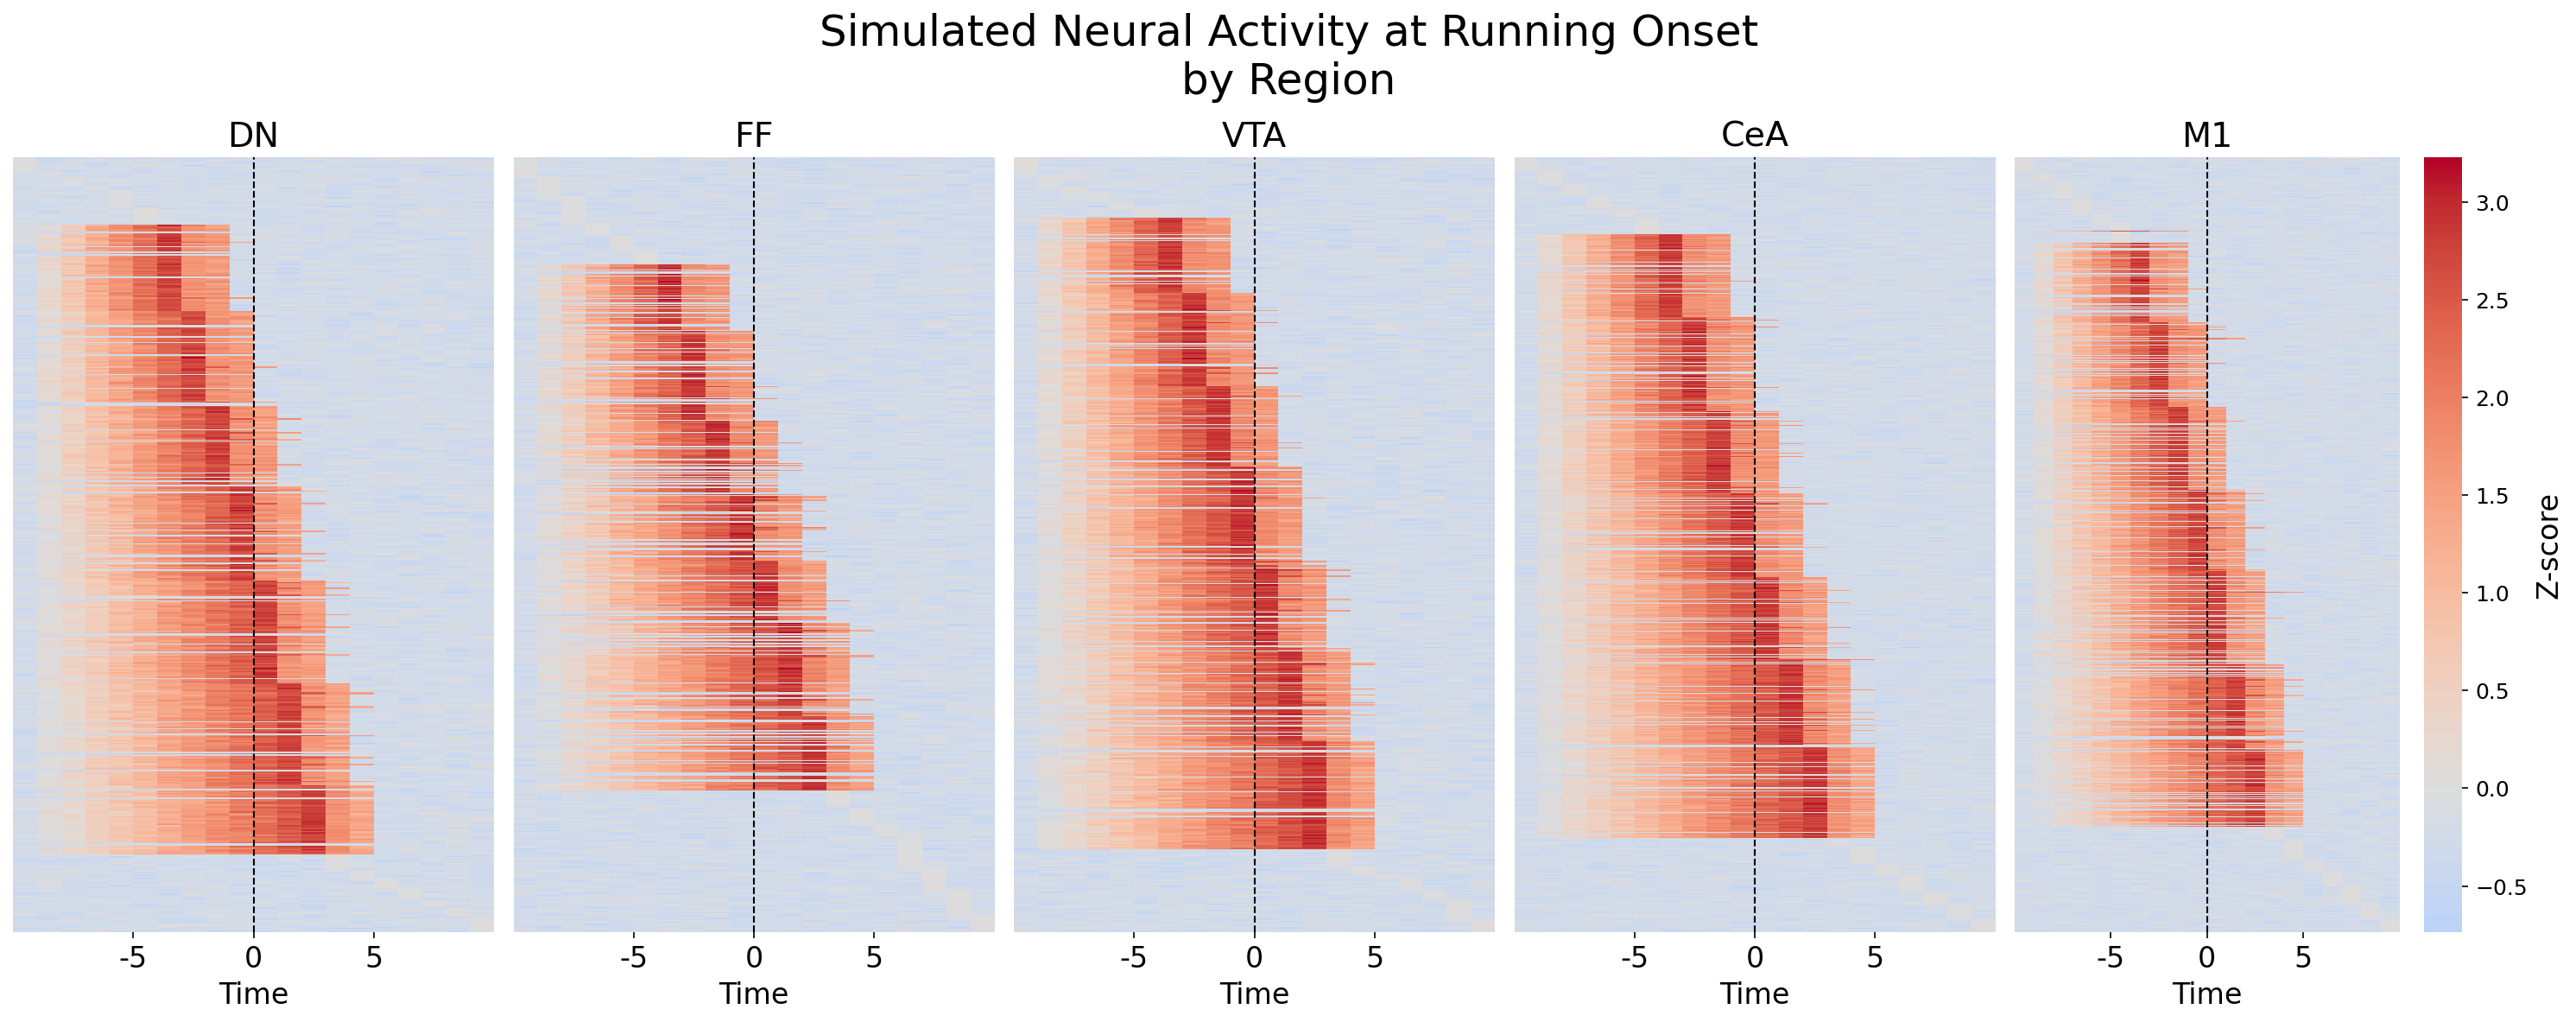

In [228]:


# Just made the plotting a function since it is repeated
def plot_region_heatmaps(data, neuron_counts= neuron_counts, Title = "Simulated Neural Activity at Running Onset\nby Region"):
    # Initialize a dictionary to organize time series by region
    region_time_series = {region: [] for region in neuron_counts.keys()}
    
    # Populate the region_time_series dictionary with sorted time series from `all_neuron_data`
    for region, neuron_id, time_series, peak_time in data:
        # Append each time series and its peak time to the respective region list
        region_time_series[region].append((time_series, peak_time))

    # Sort the time series within each region by peak time
    for region, data in region_time_series.items():
        # Sort by peak time
        data.sort(key=lambda x: x[1])  
        # Replace each entry in the region with just the time series (remove peak times)
        region_time_series[region] = [x[0] for x in data]

    # Create subplots for each region
    fig, axes = plt.subplots(nrows=1, ncols=len(region_time_series), figsize=(20, 8))
    plt.rcParams.update({
        'axes.labelsize': 16,      # Axis label font size
        'xtick.labelsize': 16,     # X-tick font size
        'ytick.labelsize': 12,     # Y-tick font size
        'legend.fontsize': 16}) 
    for i, (ax, (region, time_series_list)) in enumerate(zip(axes, region_time_series.items())):
        # Convert the list of time series for the region into a NumPy array
        heatmap_data = np.array(time_series_list)

        
        # Plot heatmap without colorbar for all but the last subplot
        sns.heatmap(heatmap_data, cmap='coolwarm', cbar=(i == len(region_time_series) - 1), 
                    cbar_kws={'label': 'Z-score'} if i == len(region_time_series) - 1 else None, 
                    xticklabels=False, yticklabels=False, ax=ax, center=0)
        
        # Add a vertical dotted line at time point 0 (pre-stimulus)
        ax.axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
        
        # Set the title for the region
        ax.set_title(f"{region}", fontsize = 19)
        
        # Set the x-axis label
        ax.set_xlabel('Time')
        
        # Set x-ticks at -5, 0, and 5 (you may need to adjust based on your data range)
        ax.set_xticks([5, 10,15])
        ax.set_xticks([5, 10,15],labels = [-5,0,5])
    
    # Adjust layout and show the figure
    plt.suptitle(Title, fontsize = 24)
    plt.subplots_adjust(top = 0.5)

    plt.tight_layout()
    plt.show()

# Example usage
plot_region_heatmaps(data = roi_neuron_activity())


In [229]:
#checking that the number of time series generated is correct 


# Extract region information from the data
regions = [entry[0] for entry in roi_neuron_activity()]

# Count occurrences of each region
region_counts = Counter(regions)

dict1 = dict(region_counts)
dict2 = dataframe_to_dict(cpr.T)


equivalent = True

if dict1.keys() != dict2.keys():
    equivalent = False
else:
    for key in dict1:
        # Check if values match, accounting for lists in dict2
        if isinstance(dict2[key], list) and len(dict2[key]) == 1:
            if dict1[key] != dict2[key][0]:  # Compare with single value in list
                equivalent = False
                break
        elif dict1[key] != dict2[key]:  # Direct comparison for non-list values
            equivalent = False
            break

print("Correct number of time series simulated", equivalent)

Correct number of time series simulated True


# Simulating 2 Conditions

In [230]:
C1_response_prop= {"DN":0.75, "M1": (0.6*0.85), "VTA": 0.7*0.75, "CeA": (0.7*0.5), "FF":0.5}
C2_response_prop= {"DN":0.75*.5, "M1": 0.6, "VTA": 0.7*0.5, "CeA": (0.7*0.75), "FF":(0.5*0.5)}

In [231]:
C1_activity = roi_neuron_activity(rois_responseprop= C1_response_prop, seed=0) 
C2_activity = roi_neuron_activity(rois_responseprop= C2_response_prop, seed=1) 

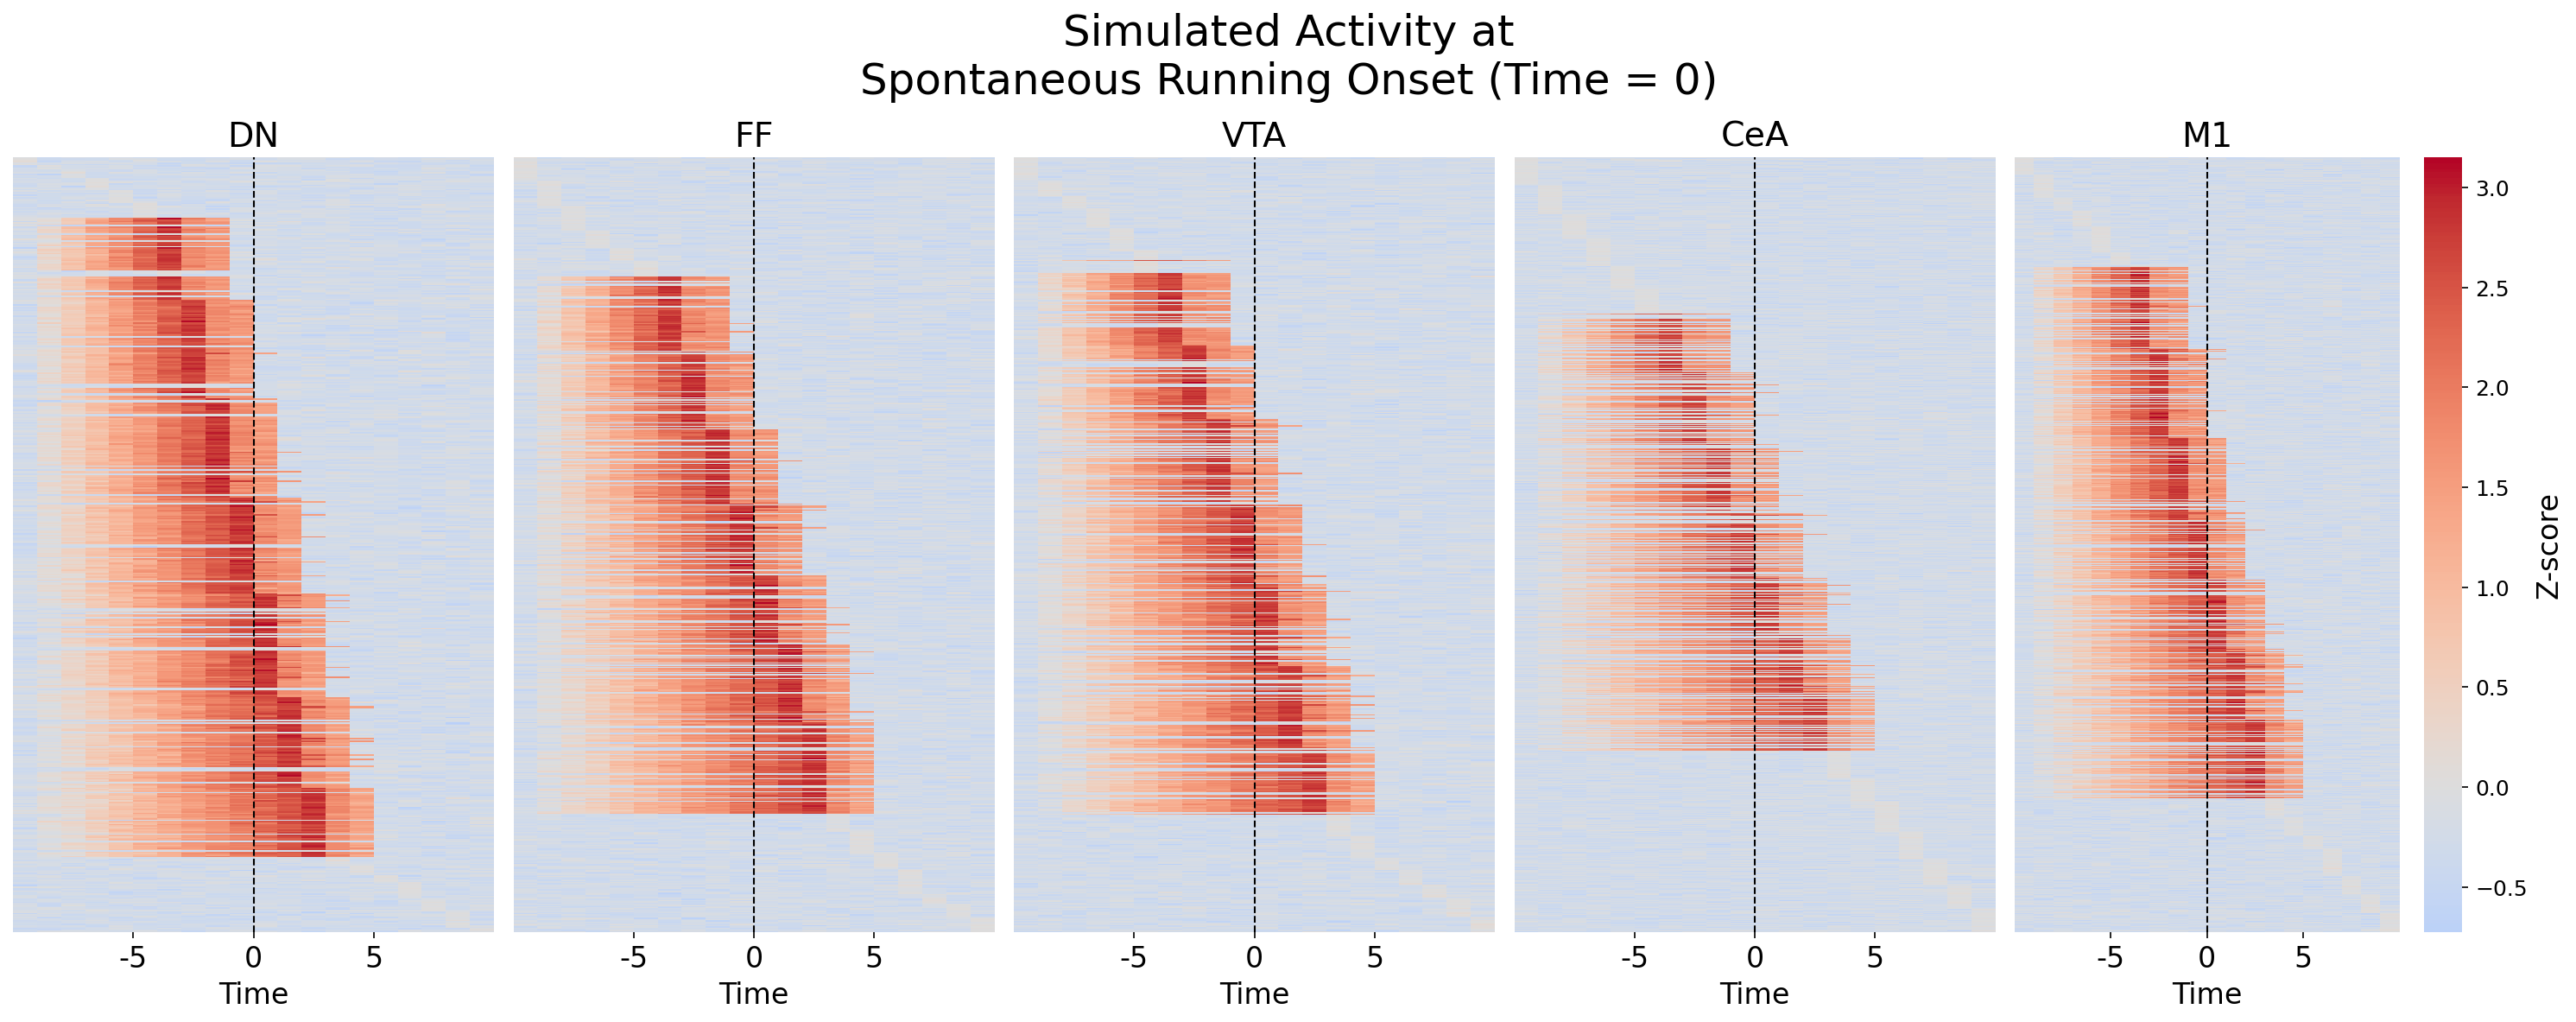

In [232]:
plot_region_heatmaps(data = C1_activity, Title ="Simulated Activity at\nSpontaneous Running Onset (Time = 0)")


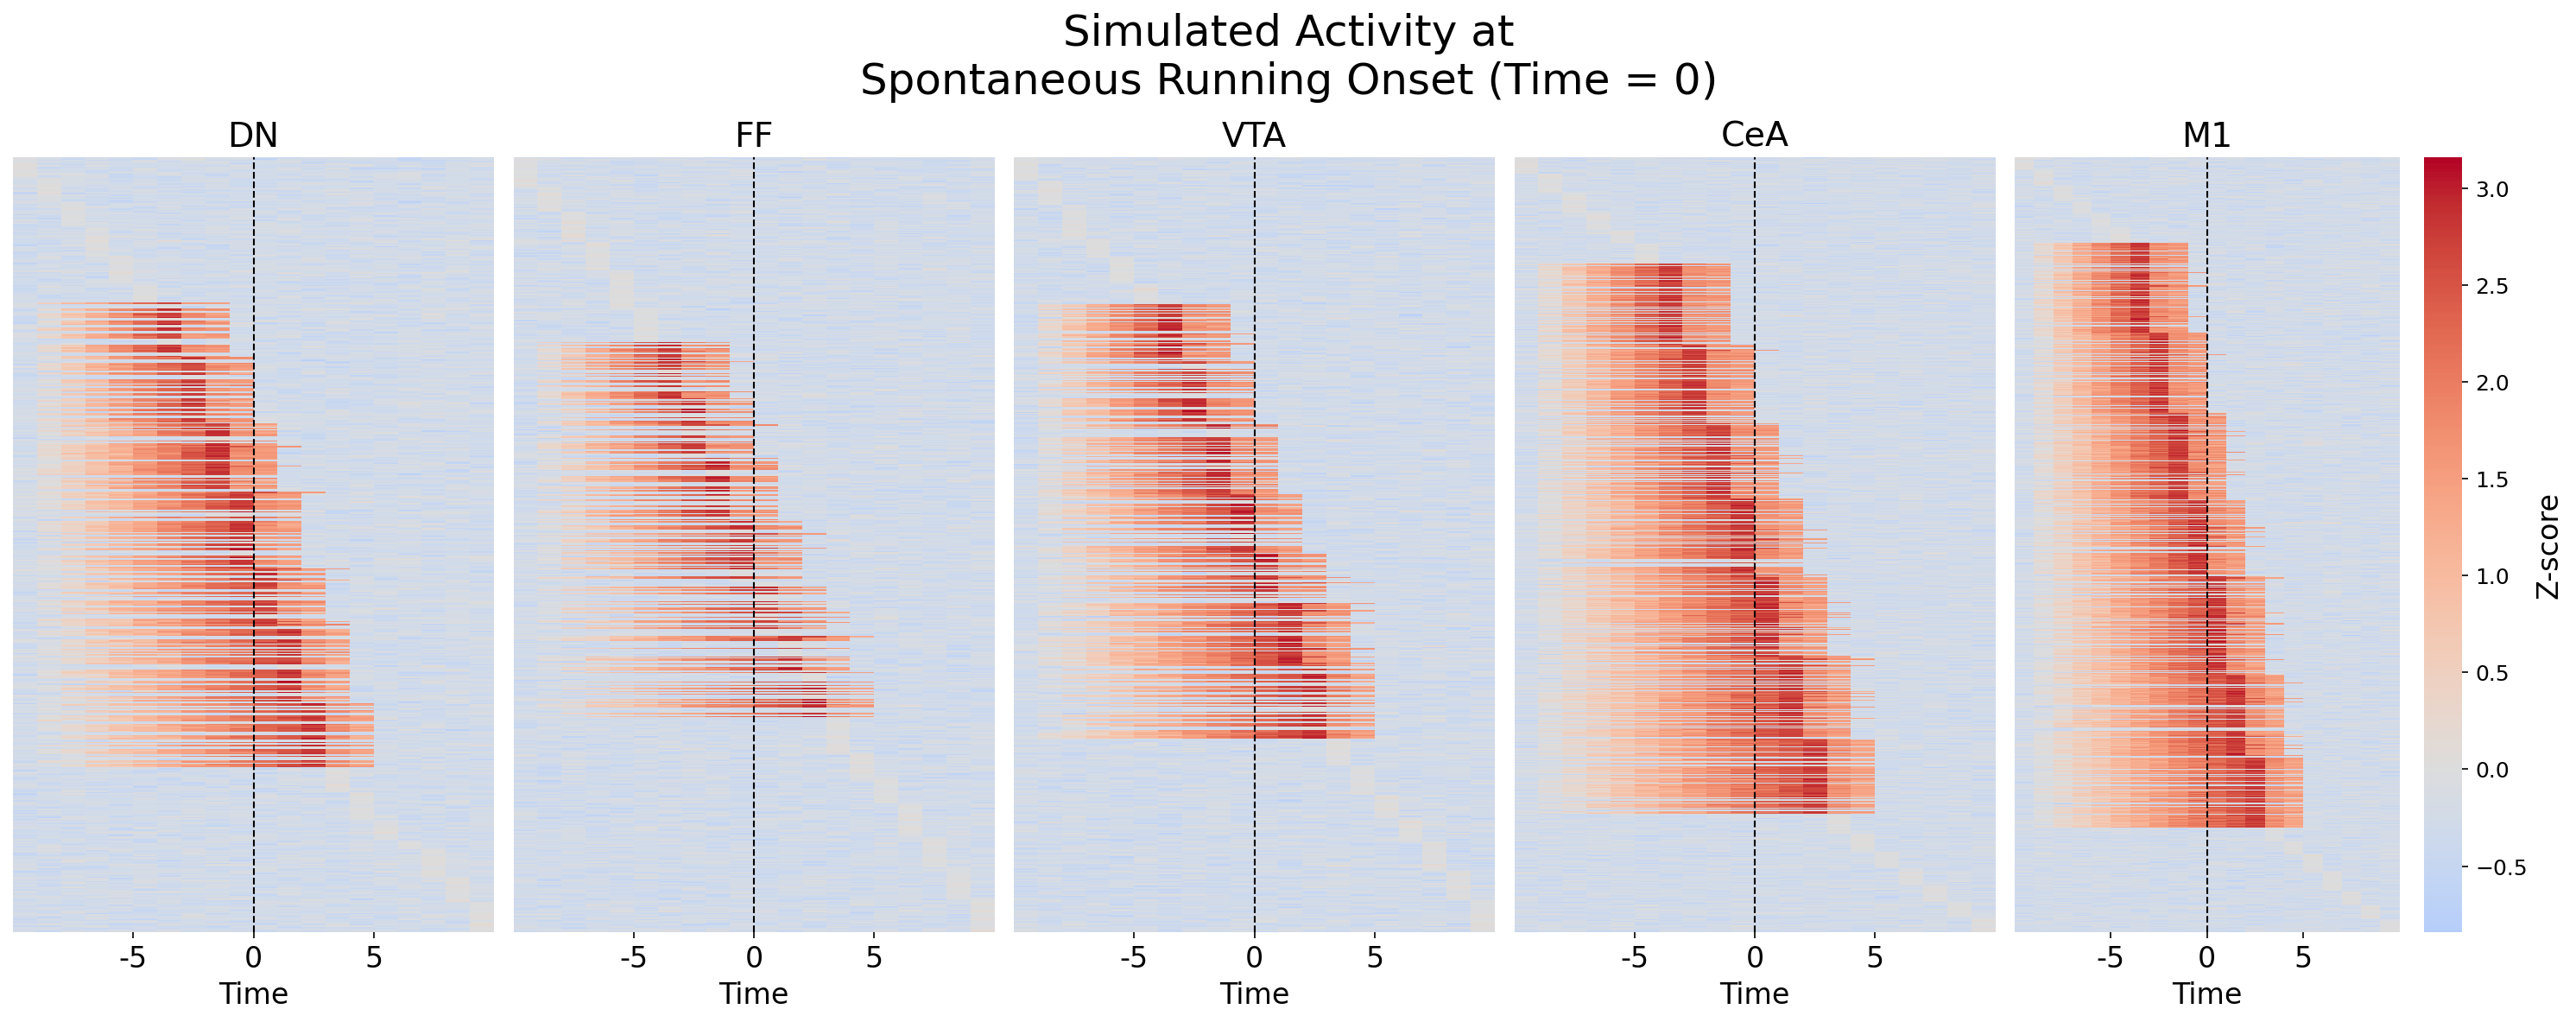

In [233]:
plot_region_heatmaps(data = C2_activity, Title ="Simulated Activity at\nSpontaneous Running Onset (Time = 0)")

In [234]:
# 1. Calculate the average value of each cell's time series for each condition
def get_average_activity_by_region(activity_data):
    region_avg_activity = {}
    
    for region, neuron_id, timeseries, peak_time in activity_data:
        # Calculate the mean of the timeseries for this neuron
        avg_activity = np.mean(timeseries)
        
        # Add this neuron's average to the region's list of averages
        if region not in region_avg_activity:
            region_avg_activity[region] = []
        
        region_avg_activity[region].append(avg_activity)
    
    return region_avg_activity

# Calculate average activity for each condition (C1 and C2)
C1_avg_activity = get_average_activity_by_region(C1_activity)
C2_avg_activity = get_average_activity_by_region(C2_activity)

# 2. Perform paired t-tests by region
t_test_results = {}
p_values = []  # To collect p-values for multiple comparisons correction

# Get the list of regions (common to both C1 and C2)
regions = list(C1_avg_activity.keys())

for region in regions:
    # Get the average activity for this region in both conditions
    avg_c1 = C1_avg_activity[region]
    avg_c2 = C2_avg_activity[region]
    
    # Ensure the lengths match between C1 and C2 data for the same region
    if len(avg_c1) == len(avg_c2):
        # Perform paired t-test (two-tailed)
        t_stat, p_value = stats.ttest_rel(avg_c1, avg_c2)
        
        # Store the results
        t_test_results[region] = {'t_stat': t_stat, 'p_value': p_value}
        p_values.append(p_value)
    else:
        # If the number of units is not the same, store an error message
        t_test_results[region] = {'t_stat': None, 'p_value': 'Mismatched cell counts'}

# Convert results to a DataFrame for better readability
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

# 3. Apply multiple comparisons correction
# FDR correction (Benjamini-Hochberg)
_, p_values_corrected_fdr, _, _ = multipletests(p_values, method='fdr_bh')

# Bonferroni correction
p_values_corrected_bonf = multipletests(p_values, method='bonferroni')[1]

# Add corrected p-values to the DataFrame
t_test_results_df['p_value_fdr_corrected'] = p_values_corrected_fdr
t_test_results_df['p_value_bonferroni_corrected'] = p_values_corrected_bonf

# Display the results
print(t_test_results_df)


        t_stat       p_value  p_value_fdr_corrected  \
DN   11.156248  3.175468e-26           5.292446e-26   
FF   13.851859  2.085817e-38           1.042909e-37   
VTA   6.603370  8.527666e-11           1.065958e-10   
CeA -13.140846  6.019119e-38           1.504780e-37   
M1   -4.585866  5.186349e-06           5.186349e-06   

     p_value_bonferroni_corrected  
DN                   1.587734e-25  
FF                   1.042909e-37  
VTA                  4.263833e-10  
CeA                  3.009560e-37  
M1                   2.593174e-05  


# Clustering units based on time series and condition

In [243]:
def prepare_clustering_data(C1_activity, C2_activity):
    # Concatenate time series for each cell across the two conditions
    combined_activity = []
    for (region1, neuron_id1, ts1, peak_time1), (region2, neuron_id2, ts2, peak_time2) in zip(C1_activity, C2_activity):
        # Assuming each neuron is matched by ID across both conditions
        combined_ts = np.concatenate([ts1, ts2])
        combined_activity.append(combined_ts)
    
    # Convert to array
    combined_activity = np.array(combined_activity)

    #
    
    return combined_activity

def cluster_units(combined_activity, n_clusters=3, run_pca = False):
    ''' when run_pca = True, the clustering is based on the principle components. Various reasons to do this, but the one that is most
    convincing in this instance is "Focus on Main Variance: By using the top components 
    from PCA, we focus the clustering algorithm on the primary sources of variation in the data. 
    This typically aligns well with biological patterns, where certain variance sources correspond to distinct 
    cell types or response profiles" - ChatGPT
    '''
    # Dimensionality reduction (optional but recommended by ChatGPT)
    if run_pca:
        pca = PCA(n_components=10)  # Adjust components based on variance explained
        activity = reduced_activity = pca.fit_transform(combined_activity)

    else:
        activity = combined_activity
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0) #setting random_state = 0 is essentially seeding the random number generator used by the clustering algorithm 
    clusters = kmeans.fit_predict(activity) #this is fitting the clusters to the data and determining which units fall into which clusters
    
    return clusters

def get_cluster_average_time_series(C1_activity, C2_activity, clusters):
    ''' getting the average and SEM of the time series by cluster'''
    # Determine the number of clusters
    n_clusters = len(set(clusters))

    # Initialize dictionaries to hold time series for each cluster in each condition
    C1_cluster_data = defaultdict(list)
    C2_cluster_data = defaultdict(list)

    # Separate units by cluster
    for (region1, neuron_id1, ts1, peak_time1), (region2, neuron_id2, ts2, peak_time2), cluster_id in zip(C1_activity, C2_activity, clusters):
        C1_cluster_data[cluster_id].append(ts1)
        C2_cluster_data[cluster_id].append(ts2)

    # Compute the average and SEM (for confidence intervals) time series for each cluster
    C1_cluster_avg = {}
    C2_cluster_avg = {}
    C1_cluster_sem = {}
    C2_cluster_sem = {}
    for cluster_id in range(n_clusters):
        C1_cluster_avg[cluster_id] = np.mean(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_avg[cluster_id] = np.mean(C2_cluster_data[cluster_id], axis=0)
        C1_cluster_sem[cluster_id] = sem(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_sem[cluster_id] = sem(C2_cluster_data[cluster_id], axis=0)
    
    return C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem


In [244]:
# Prepare data and perform clustering
combined_activity = prepare_clustering_data(C1_activity, C2_activity)

### Identifying the Optimal Number of Clusters

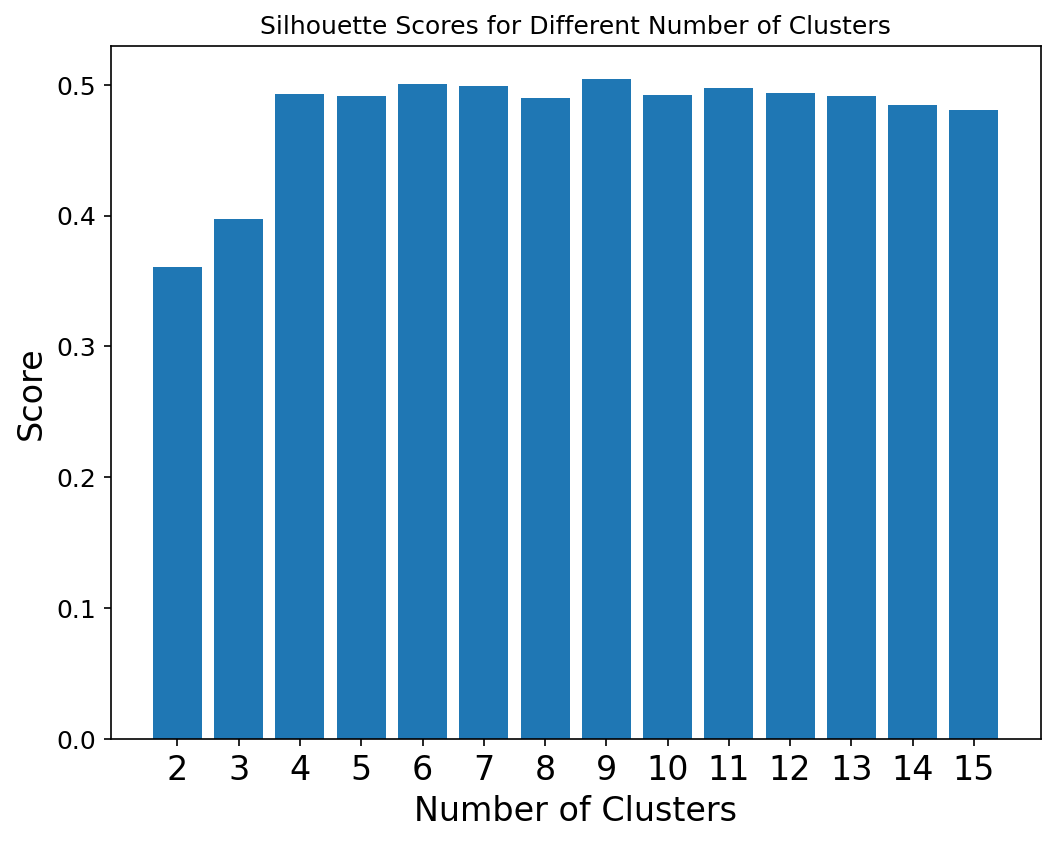

In [270]:
min_clusters=2
max_clusters=15
silhouette_scores = []

# Try clustering with different values of n_clusters
for n_clusters in range(min_clusters, max_clusters+1):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(combined_activity)
    
    # Calculate silhouette score
    score = silhouette_score(combined_activity, clusters)
    silhouette_scores.append(score)
    
# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.bar(range(min_clusters, max_clusters+1), silhouette_scores)
plt.title("Silhouette Scores for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
#plt.ylim((0.310,0.6))
plt.xticks(range(min_clusters, max_clusters+1))
plt.show()
    





In [269]:
top_cluster_nums = []

temp = silhouette_scores
x = 0

while x<4:
    i = np.argmax(temp)
    top_cluster_nums.append(i+2)
    temp[i] = 0 
    x+=1

top_cluster_nums

[9, 6, 7, 11]

For n_clusters = 9, the average silhouette_score is : 0.7288330644109474
For n_clusters = 6, the average silhouette_score is : 0.7640162987092992
For n_clusters = 7, the average silhouette_score is : 0.7114183196495514
For n_clusters = 11, the average silhouette_score is : 0.6864775937405595


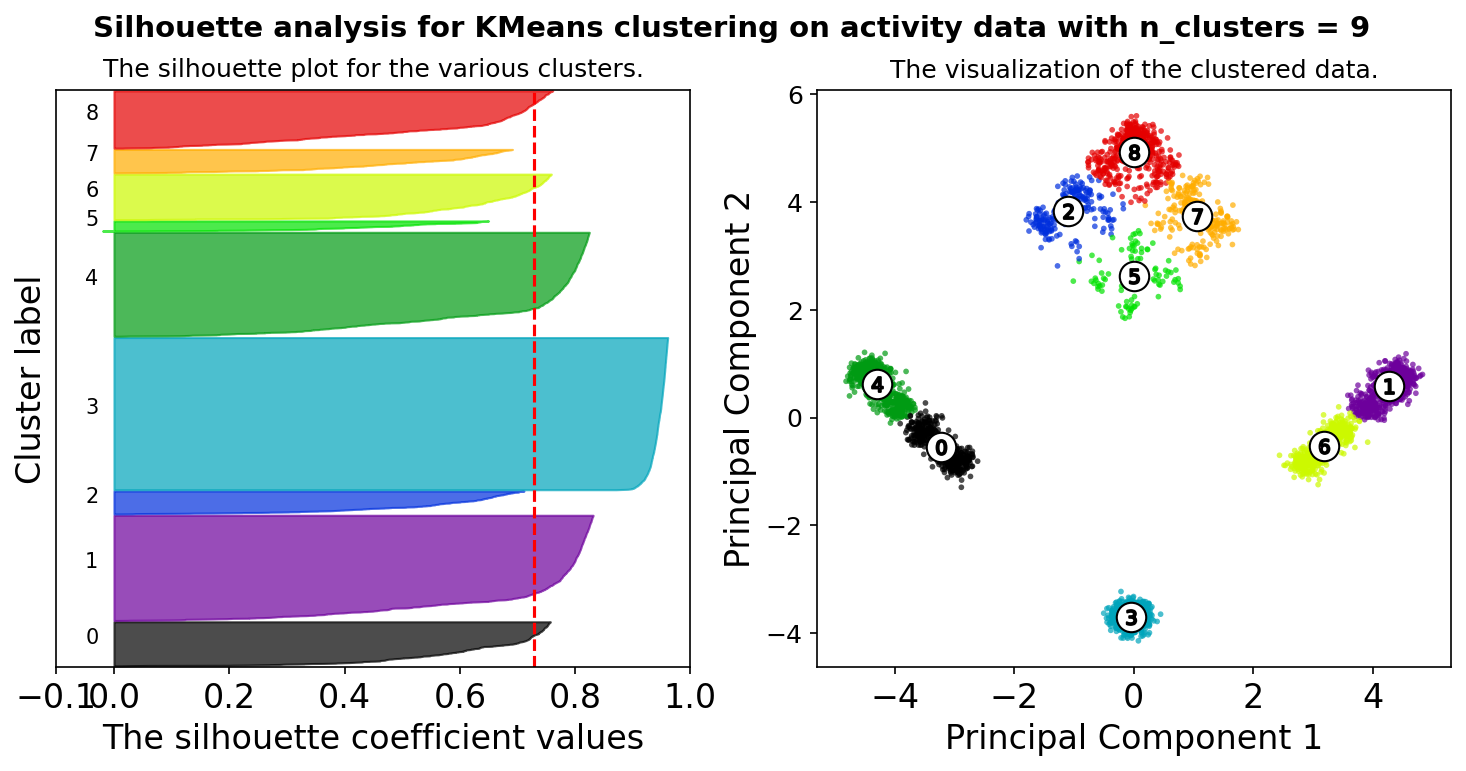

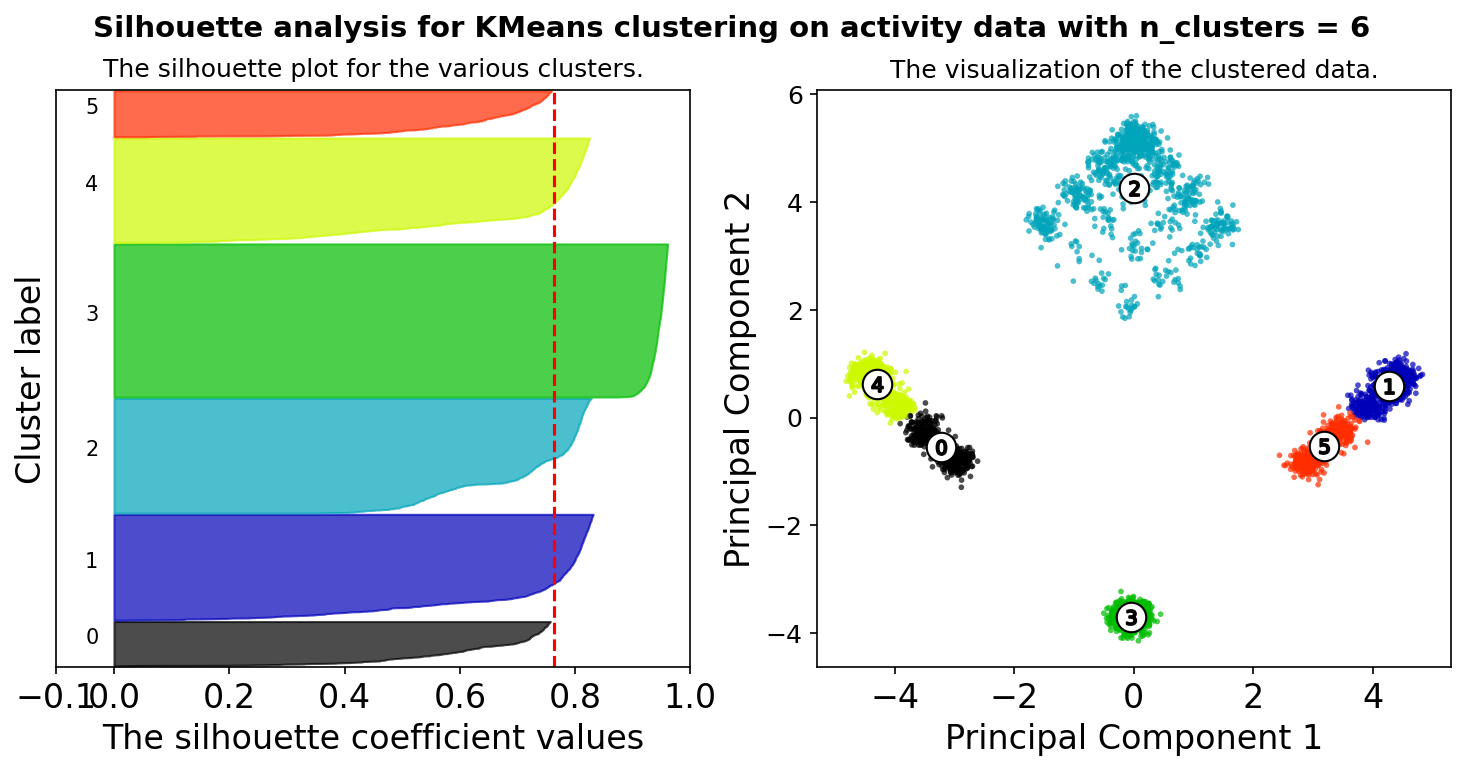

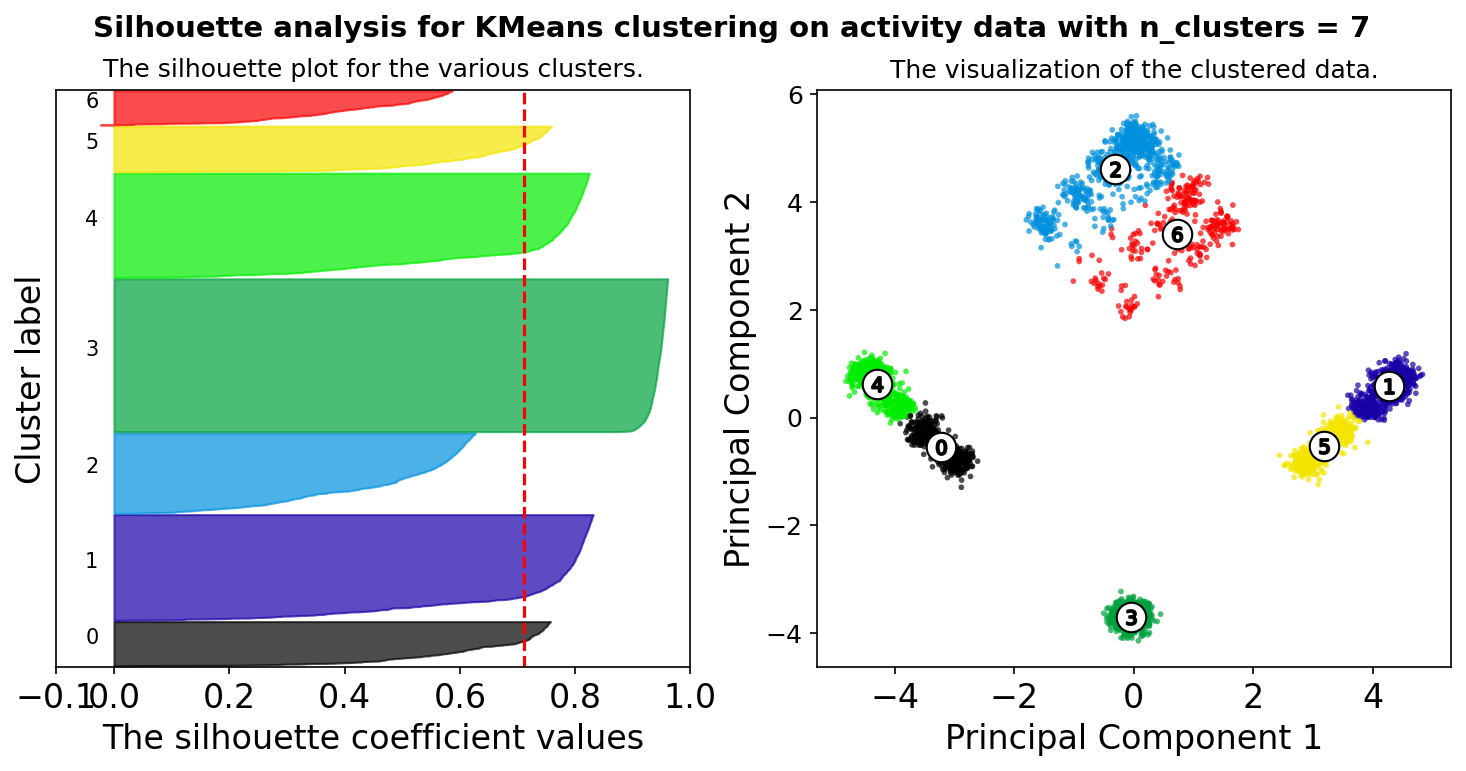

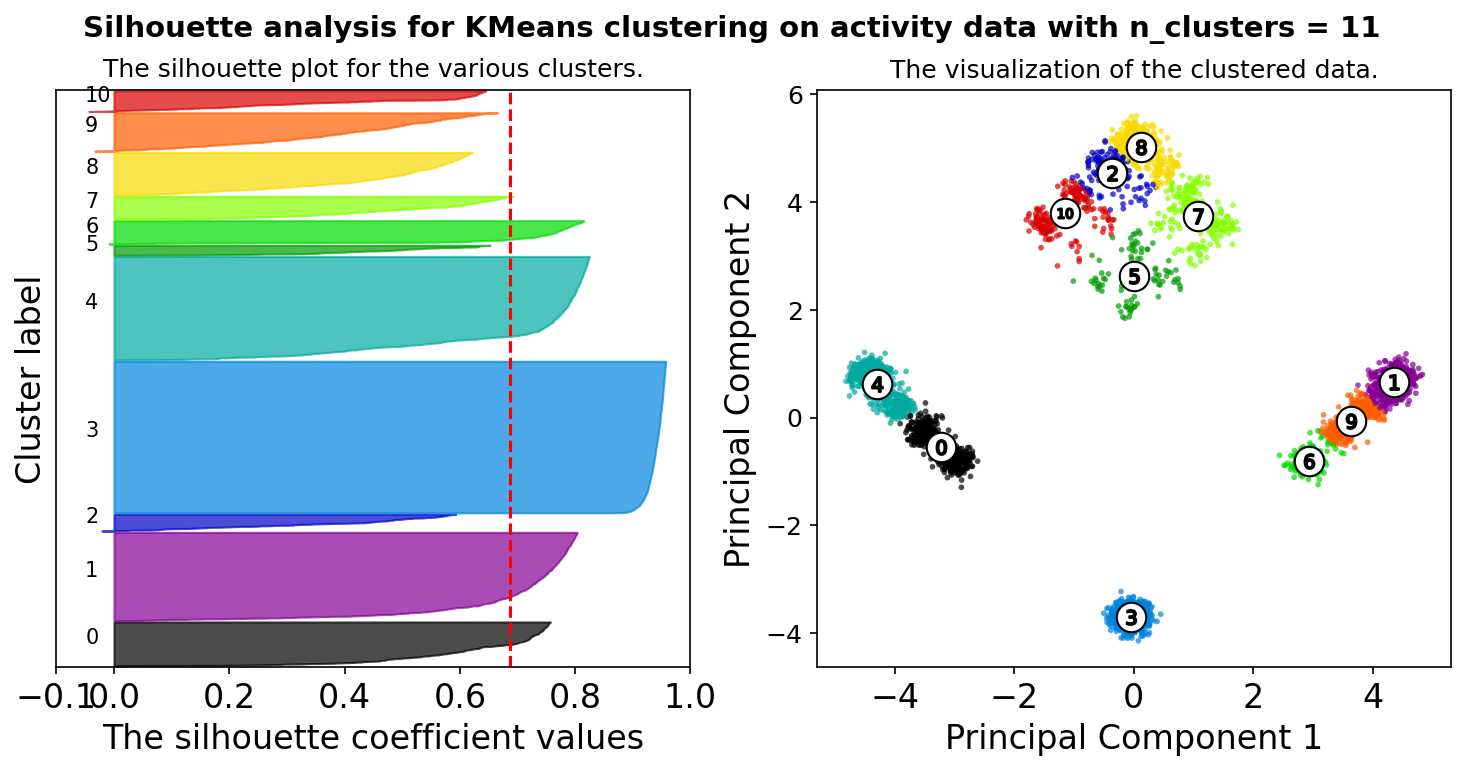

In [256]:


def visualize_silhouette_analysis(combined_activity, top_n_clusters = top_cluster_nums):
    # Reduce the dimensionality of the data to 2D for visualization purposes
    pca = PCA(n_components=2)
    reduced_activity = pca.fit_transform(combined_activity)

    for n_clusters in top_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # The silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(reduced_activity) + (n_clusters + 1) * 10])

        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(reduced_activity)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(reduced_activity, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(reduced_activity, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(reduced_activity[:, 0], reduced_activity[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

        # Labeling the clusters
        centers = kmeans.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Principal Component 1")
        ax2.set_ylabel("Principal Component 2")

        plt.suptitle(f"Silhouette analysis for KMeans clustering on activity data with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")

    plt.show()

# Example usage with your normalized_activity data
visualize_silhouette_analysis(combined_activity)


In [271]:
num_clusters = top_cluster_nums[0] #the first value in this list had the highest sillhouette value
num_clusters = 6

clusters = cluster_units(combined_activity, n_clusters=num_clusters, run_pca= False)
C1_cluster_avg, C2_cluster_avg,C1_cluster_sem,C2_cluster_sem = get_cluster_average_time_series(C1_activity, C2_activity, clusters)

In [272]:


def calculate_95ci(avg, sem, n_units):
    """Calculate the 95% confidence interval."""
    ci_upper = avg + 1.96 * (sem / np.sqrt(n_units))
    ci_lower = avg - 1.96 * (sem / np.sqrt(n_units))
    return ci_lower, ci_upper

def plot_time_series_with_ci(ax, avg_c1, avg_c2, sem_c1, sem_c2, n_units_c1, n_units_c2, cluster_id):
    """Plot time series with shaded 95% CI for C1 and C2."""
    # Calculate the 95% CI for C1 and C2
    C1_ci_lower, C1_ci_upper = calculate_95ci(avg_c1, sem_c1, n_units_c1)
    C2_ci_lower, C2_ci_upper = calculate_95ci(avg_c2, sem_c2, n_units_c2)

    # Plot the average time series for C1 and C2 (different colors)
    ax.plot(avg_c1, label='Spontaneous', color='blue')
    ax.plot(avg_c2, label='Escape', color='red')

    # Plot the 95% CI as shaded areas around the mean (C1 and C2)
    ax.fill_between(range(len(avg_c1)), C1_ci_lower, C1_ci_upper, color='blue', alpha=0.2)
    ax.fill_between(range(len(avg_c2)), C2_ci_lower, C2_ci_upper, color='red', alpha=0.2)

    # Set titles and labels
    ax.set_title(f'Cluster {cluster_id + 1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Activity (Z-scores)')
    ax.legend()

def plot_cluster_time_series(C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem, C1_n_units, C2_n_units):
    """Plot average time series for each cluster with 95% CI."""
    # Determine global min/max for uniform y-axis range
    all_data = list(C1_cluster_avg.values()) + list(C2_cluster_avg.values())
    min_value = min([min(cluster) for cluster in all_data]) - 0.1
    max_value = max([max(cluster) for cluster in all_data]) + 0.1

    # Create subplots for each cluster
    fig, axes = plt.subplots(len(C1_cluster_avg), 1, figsize=(10, 3 * len(C1_cluster_avg)))

    # Plot each cluster
    for cluster_id in range(len(C1_cluster_avg)):
        plot_time_series_with_ci(axes[cluster_id], 
                                 C1_cluster_avg[cluster_id], C2_cluster_avg[cluster_id], 
                                 C1_cluster_sem[cluster_id], C2_cluster_sem[cluster_id], 
                                 C1_n_units, C2_n_units, cluster_id)

        # Set uniform y-axis range across all clusters
        axes[cluster_id].set_ylim(min_value, max_value)

    # Set the overall title and adjust layout
    plt.suptitle('Average Time Series for Each Cluster', fontsize=16)
    plt.subplots_adjust(top=0.85, hspace=0.8)
    plt.show()


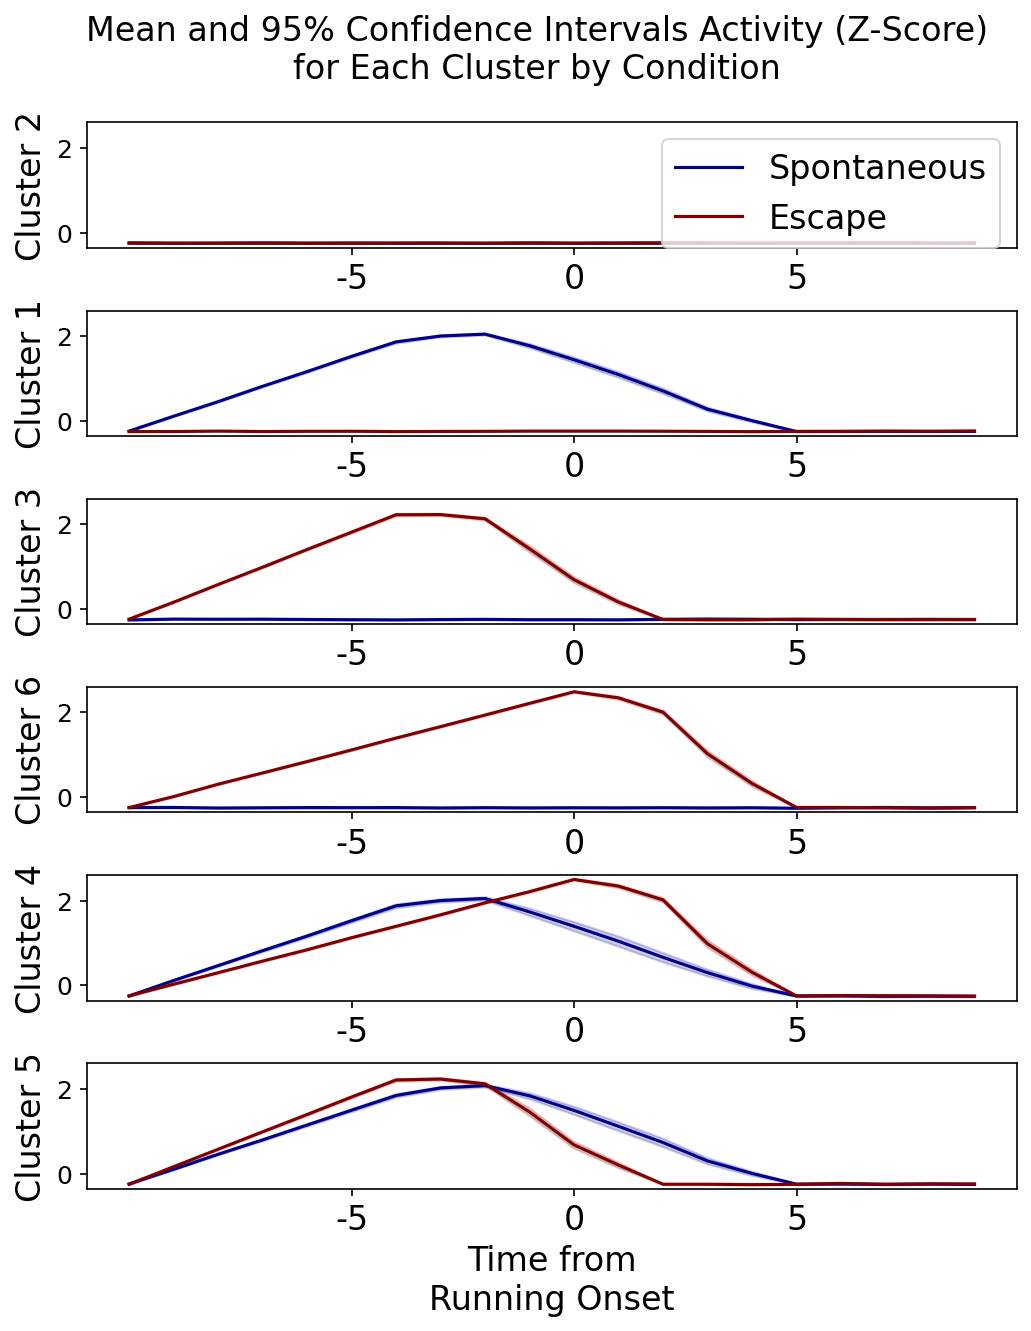

In [346]:
# Define the new order for clusters
cluster_order = [2, 1, 3, 6, 4, 5]

# Extract values (list of time series) from the dictionaries
C1_values = list(C1_cluster_avg.values())  # List of time series for C1
C2_values = list(C2_cluster_avg.values())  # List of time series for C2

# Combine C1 and C2 data to find the global min and max
all_data = C1_values + C2_values  # Concatenate both C1 and C2 lists
min_value = min([min(cluster) for cluster in all_data]) - 0.1  # A small buffer below the minimum
max_value = max([max(cluster) for cluster in all_data]) + 0.1  # A small buffer above the maximum

# Create subplots for each cluster
fig, axes = plt.subplots(len(cluster_order), 1, figsize=(8, 1.5 * len(cluster_order)))  # Shorter height for each subplot

# Scaling factor for 95% CI
ci_scale = 1.96

for plot_idx, cluster_id in enumerate(cluster_order):
    # Subtract 1 from cluster_id to match zero-based indexing
    cluster_idx = cluster_id - 1

    # Plot the average time series for C1 and C2 (different colors)
    axes[plot_idx].plot(C1_cluster_avg[cluster_idx], label='Spontaneous', color='darkblue')
    axes[plot_idx].plot(C2_cluster_avg[cluster_idx], label='Escape', color='maroon')

    # Plot the 95% CI as shaded areas around the mean (C1 and C2)
    axes[plot_idx].fill_between(range(len(C1_cluster_avg[cluster_idx])), 
                                C1_cluster_avg[cluster_idx] - ci_scale * C1_cluster_sem[cluster_idx],
                                C1_cluster_avg[cluster_idx] + ci_scale * C1_cluster_sem[cluster_idx],
                                color='darkblue', alpha=0.2)
    axes[plot_idx].fill_between(range(len(C2_cluster_avg[cluster_idx])), 
                                C2_cluster_avg[cluster_idx] - ci_scale * C2_cluster_sem[cluster_idx],
                                C2_cluster_avg[cluster_idx] + ci_scale * C2_cluster_sem[cluster_idx],
                                color='maroon', alpha=0.2)

    # Set titles and labels
    axes[plot_idx].set_ylabel(f'Cluster {cluster_id}')
    axes[plot_idx].set_xticks([5, 10, 15], [-5, 0, 5])

    # Set uniform y-axis range across all clusters
    axes[plot_idx].set_ylim(min_value, max_value)
    


axes[0].legend(loc ="upper right")

axes[plot_idx].set_xlabel("Time from\nRunning Onset")


# Set the overall title
plt.suptitle('Mean and 95% Confidence Intervals Activity (Z-Score)\nfor Each Cluster by Condition', fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()


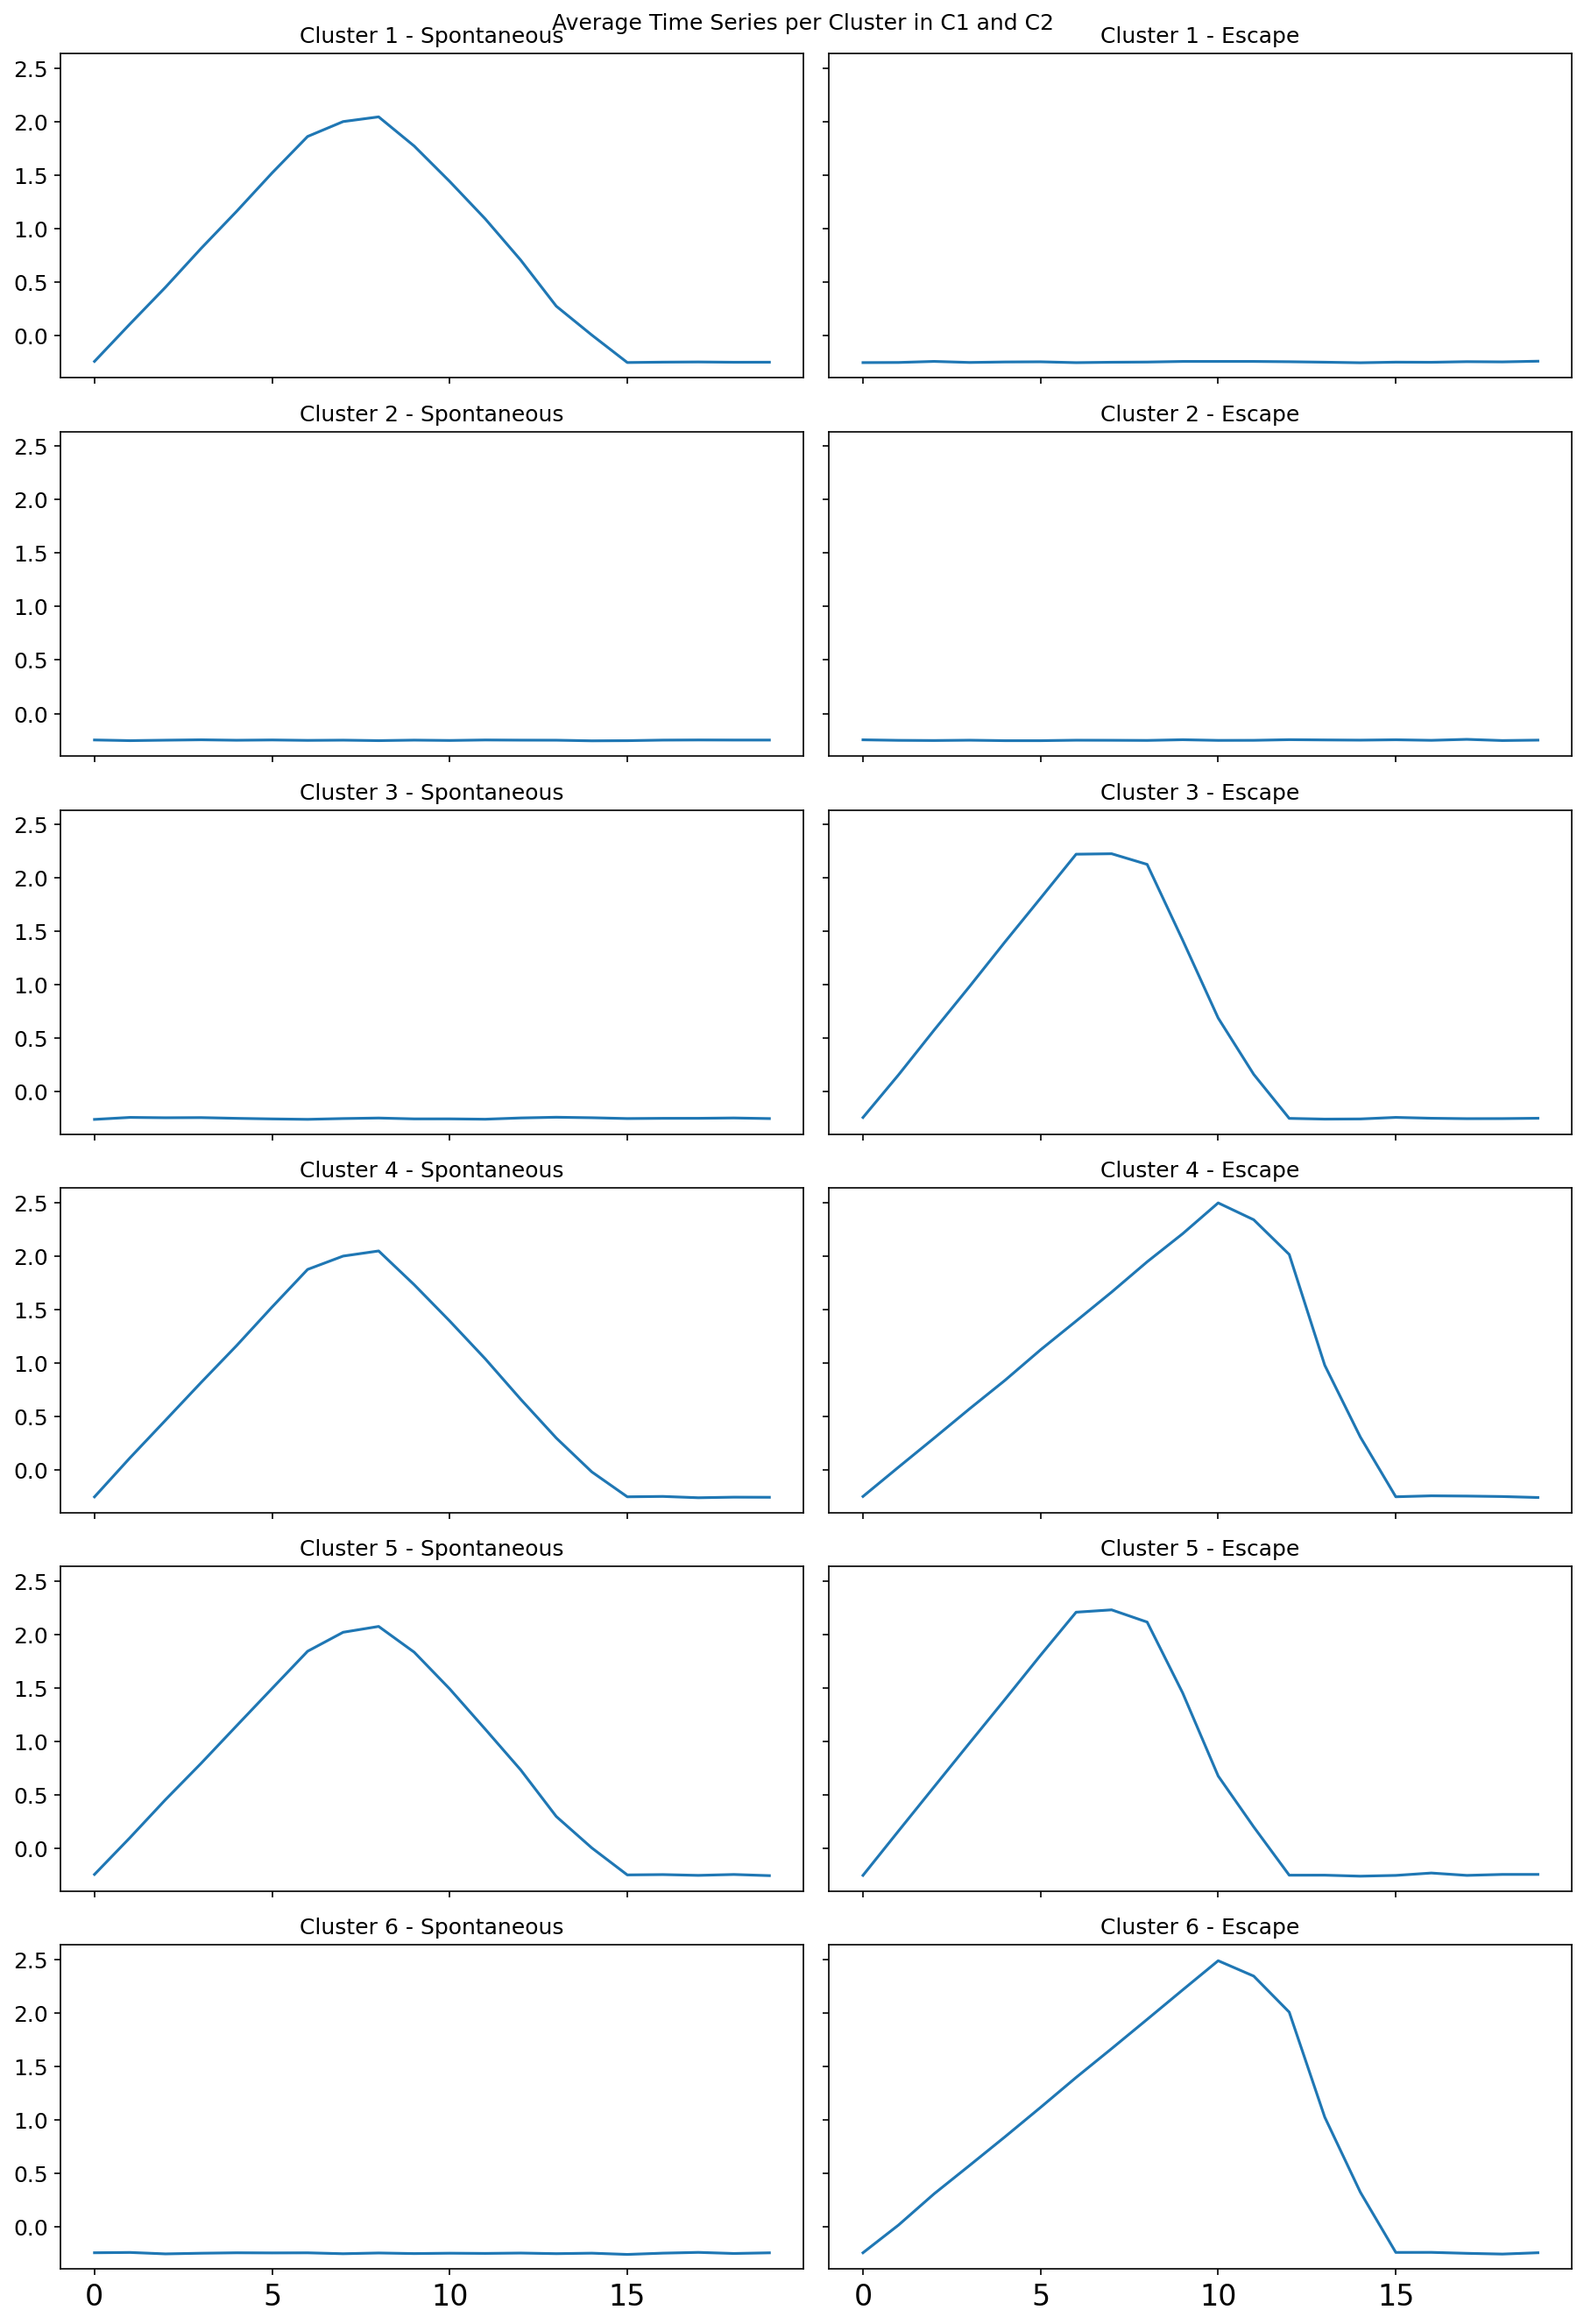

In [331]:
C1_cluster_avg, C2_cluster_avg,C1_cluster_sem,C2_cluster_sem = get_cluster_average_time_series(C1_activity, C2_activity, clusters)


fig, axes = plt.subplots(len(C1_cluster_avg), 2, figsize=(12, 3 * len(C1_cluster_avg)), sharex=True, sharey=True)
for cluster_id in range(len(C1_cluster_avg)):
    axes[cluster_id, 0].plot(C1_cluster_avg[cluster_id])
    axes[cluster_id, 1].plot(C2_cluster_avg[cluster_id])
    
    # Add titles and legends
    axes[cluster_id, 0].set_title(f'Cluster {cluster_id+1} - Spontaneous')
    axes[cluster_id, 1].set_title(f'Cluster {cluster_id+1} - Escape')


plt.suptitle('Average Time Series per Cluster in C1 and C2')
plt.tight_layout()
plt.show()


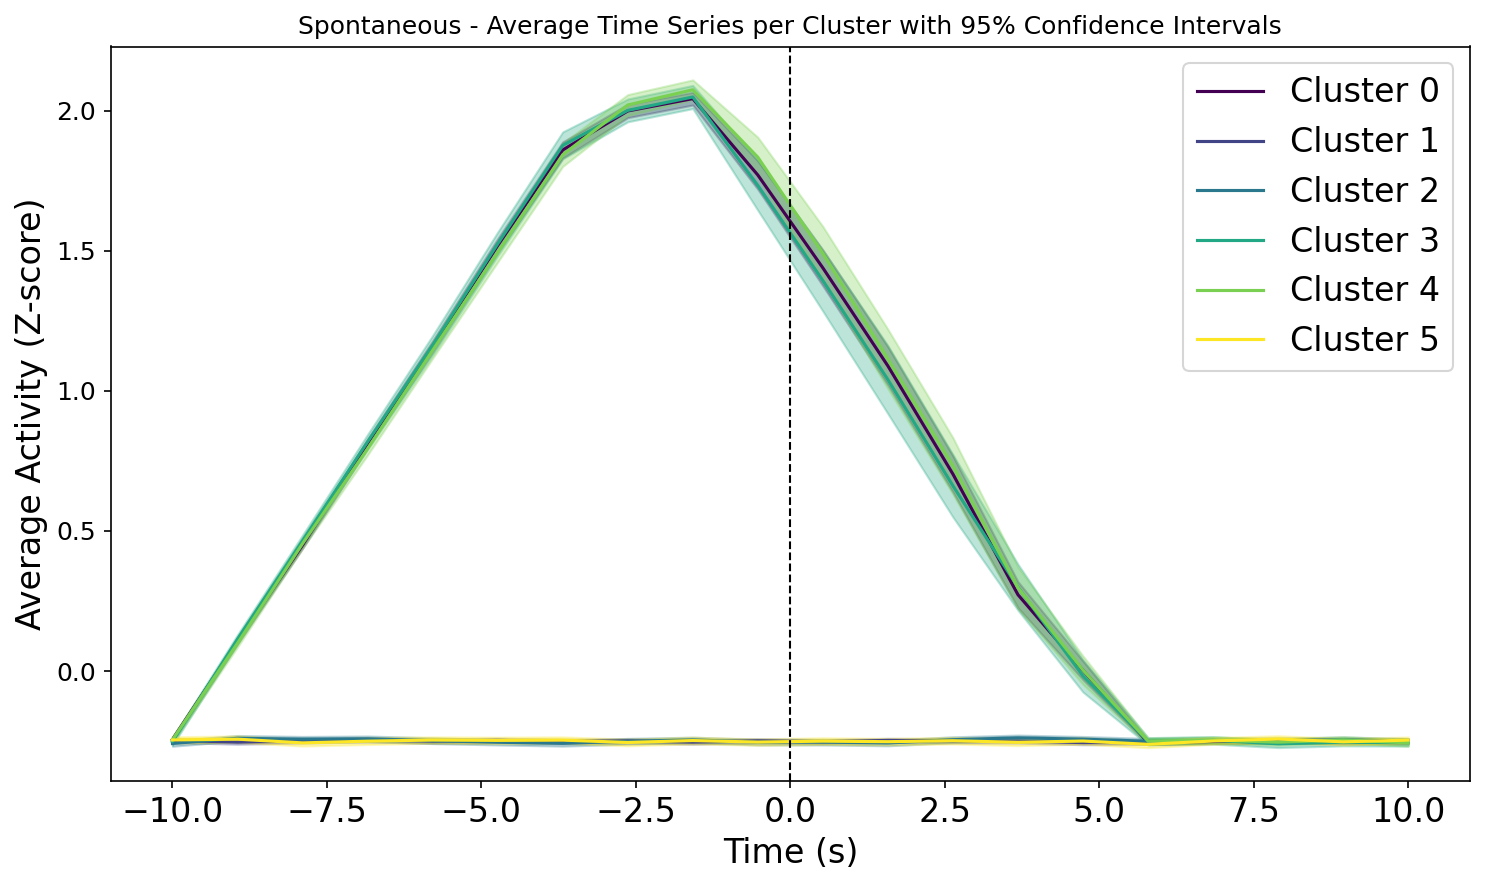

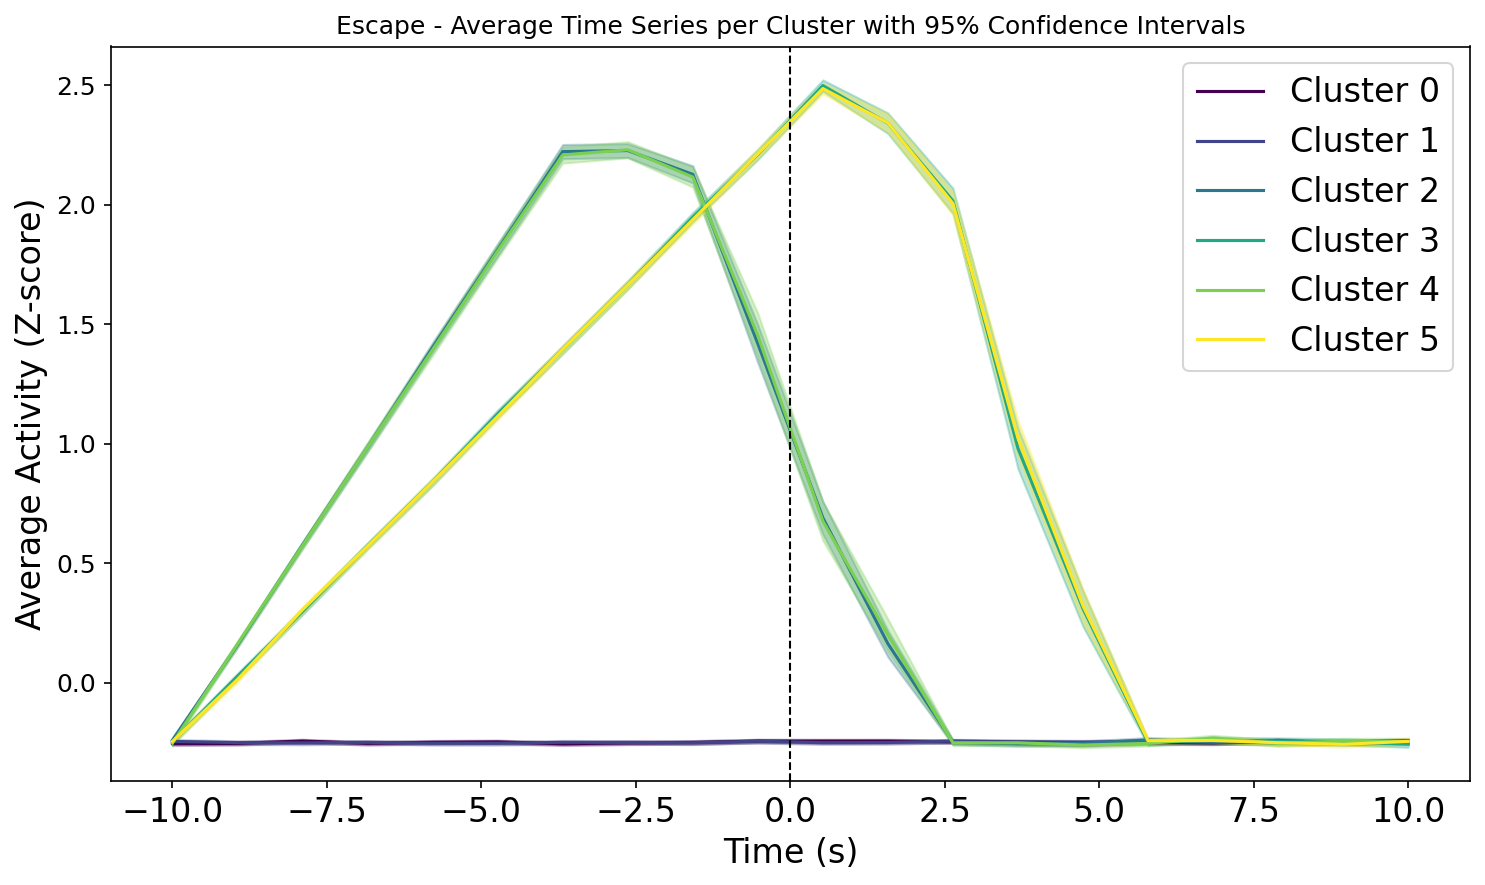

In [332]:
# Get the average and SEM time series for each cluster
C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem = get_cluster_average_time_series(C1_activity, C2_activity, clusters)

# Define x-axis time points
time_points = np.linspace(-10, 10, C1_cluster_avg[0].shape[0])

# Define colors for clusters
colors = plt.cm.viridis(np.linspace(0, 1, len(C1_cluster_avg)))

# Plotting for C1 ("Spontaneous")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C1_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C1_cluster_avg[cluster_id] - 1.96 * C1_cluster_sem[cluster_id],
        C1_cluster_avg[cluster_id] + 1.96 * C1_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Spontaneous - Average Time Series per Cluster with 95% Confidence Intervals")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Plotting for C2 ("Escape")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C2_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C2_cluster_avg[cluster_id] - 1.96 * C2_cluster_sem[cluster_id],
        C2_cluster_avg[cluster_id] + 1.96 * C2_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Escape - Average Time Series per Cluster with 95% Confidence Intervals")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


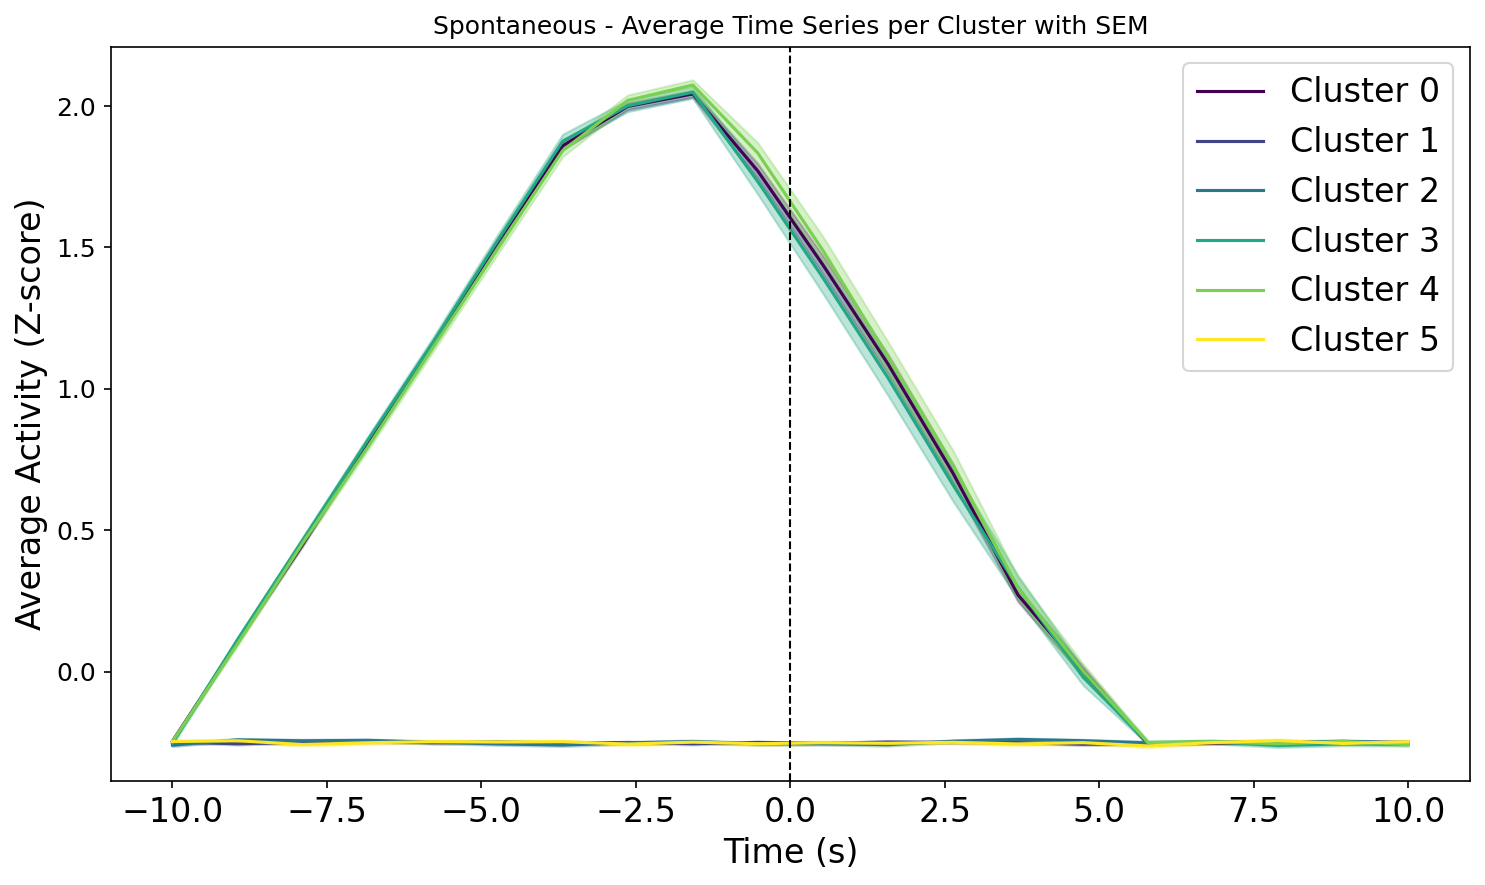

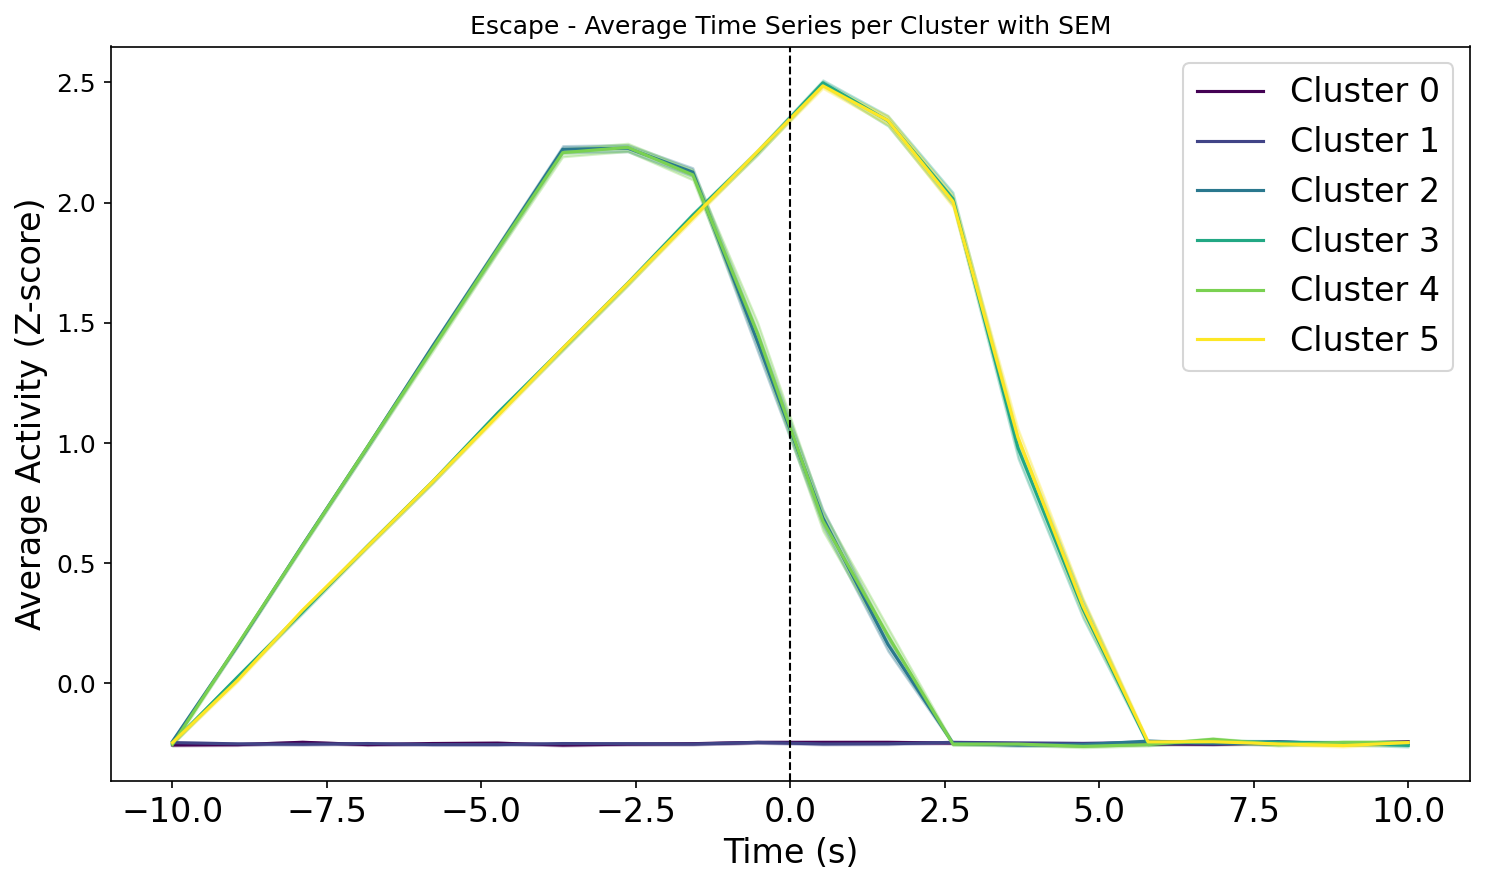

In [333]:



# Get the average and SEM time series for each cluster
C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem = get_cluster_average_time_series(C1_activity, C2_activity, clusters)

# Define x-axis time points
time_points = np.linspace(-10, 10, C1_cluster_avg[0].shape[0])

# Define colors for clusters
colors = plt.cm.viridis(np.linspace(0, 1, len(C1_cluster_avg)))

# Plotting for C1 ("Spontaneous")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C1_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C1_cluster_avg[cluster_id] - C1_cluster_sem[cluster_id],
        C1_cluster_avg[cluster_id] + C1_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Spontaneous - Average Time Series per Cluster with SEM")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Plotting for C2 ("Escape")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C2_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C2_cluster_avg[cluster_id] - C2_cluster_sem[cluster_id],
        C2_cluster_avg[cluster_id] + C2_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Escape - Average Time Series per Cluster with SEM")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [334]:


# Initialize a dictionary to hold counts per region and cluster
region_cluster_counts = defaultdict(lambda: defaultdict(int))
region_counts = defaultdict(int)

# Iterate over the data to populate region and cluster counts
for (region, neuron_id, time_series, peak_time), cluster_id in zip(C1_activity, clusters):
    region_cluster_counts[region][cluster_id] += 1
    region_counts[region] += 1

region_cluster_countsdf = pd.DataFrame(region_cluster_counts).fillna(0)

# Calculate the proportion of units in each cluster within each region
region_cluster_proportions = {}
for region, cluster_count_dict in region_cluster_counts.items():
    total_units_in_region = region_counts[region]
    region_cluster_proportions[region] = {cluster_id: count / total_units_in_region
                                              for cluster_id, count in cluster_count_dict.items()}

# Convert to DataFrame for easier viewing and analysis
region_cluster_df = pd.DataFrame(region_cluster_proportions).fillna(0)  # Fill NaNs with 0 for clusters with no units
region_cluster_df.index.name = "Cluster"
region_cluster_df.columns.name = "Region"

print("Proportion of units within each region that fall into each cluster:")
print(region_cluster_df)


Proportion of units within each region that fall into each cluster:
Region         DN        FF       VTA       CeA        M1
Cluster                                                  
5        0.053763  0.032357  0.074250  0.148362  0.139401
0        0.451613  0.442219  0.371248  0.156551  0.205069
4        0.164875  0.083205  0.088468  0.088150  0.177419
3        0.111111  0.032357  0.071090  0.087669  0.133641
1        0.157706  0.343606  0.290679  0.310694  0.170507
2        0.060932  0.066256  0.104265  0.208574  0.173963


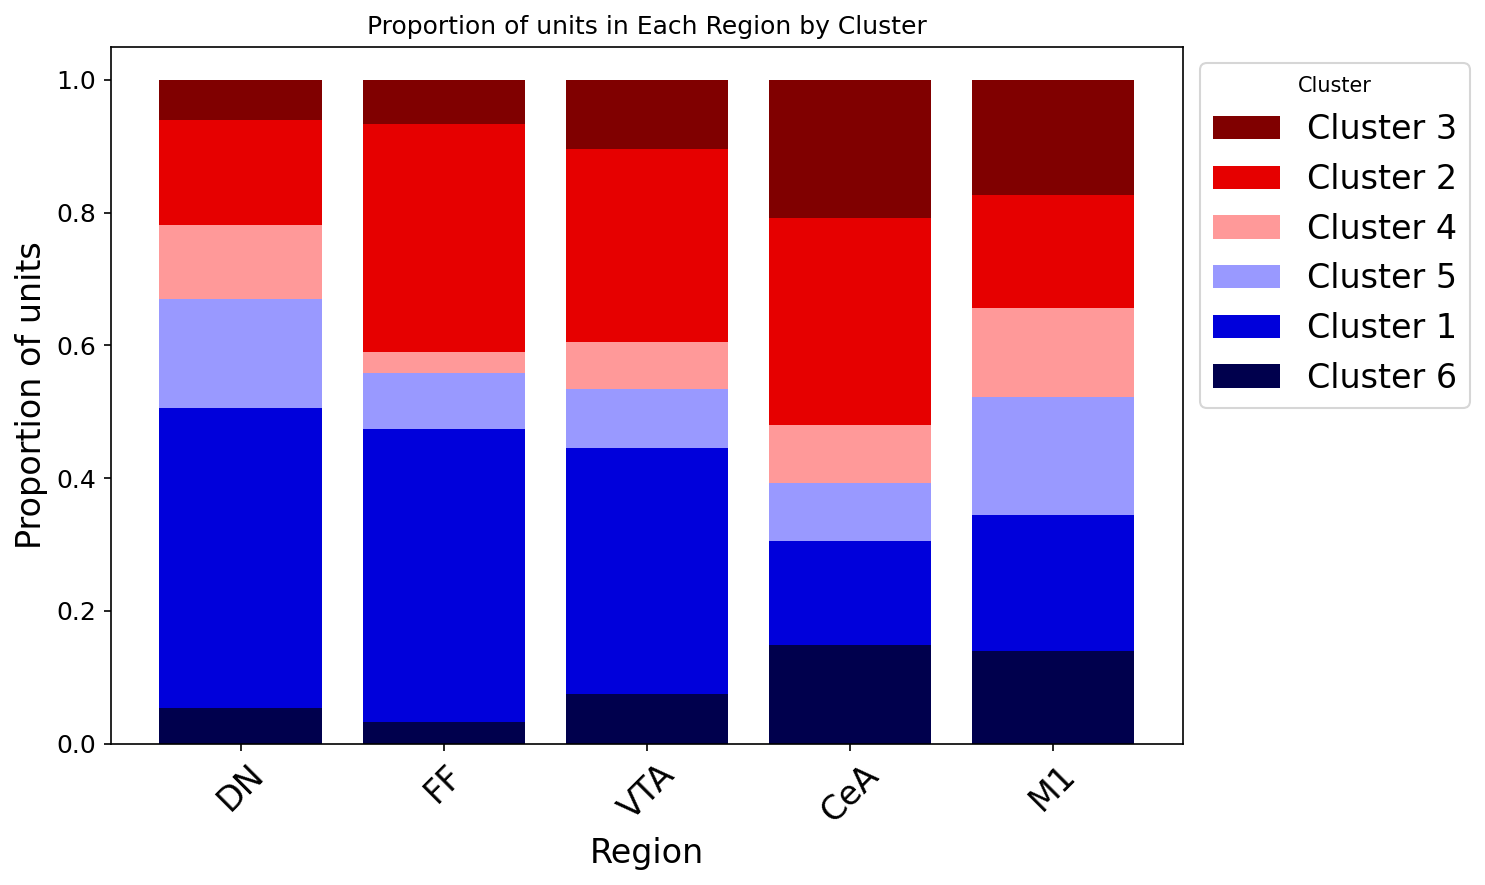

In [335]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each cluster (using Viridis colormap)
colors = plt.cm.seismic(np.linspace(0, 1, len(region_cluster_df.index)))

# Initialize bottom for stacking
bottom = np.zeros(len(region_cluster_df.columns))

# List to store bar artists and labels for the legend
bars = []
labels = []

# Plot each cluster and store legend labels in the original order
for i, (cluster, color) in enumerate(zip(region_cluster_df.index, colors)):
    bars.append(
        ax.bar(
            region_cluster_df.columns, 
            region_cluster_df.loc[cluster], 
            bottom=bottom, 
            color=color
        )
    )
    labels.append(f"Cluster {cluster + 1}")  # Corresponding label

    bottom += region_cluster_df.loc[cluster]  # Update bottom for stacking

bars_reversed = bars[::-1]
labels_reversed = labels[::-1]

# Labels and formatting
ax.set_ylabel("Proportion of units")
ax.set_xlabel("Region")
ax.set_title("Proportion of units in Each Region by Cluster")

# Manually set the legend with the bars and labels in the desired order
ax.legend(bars_reversed, labels_reversed, title="Cluster", bbox_to_anchor=(1, 1))

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


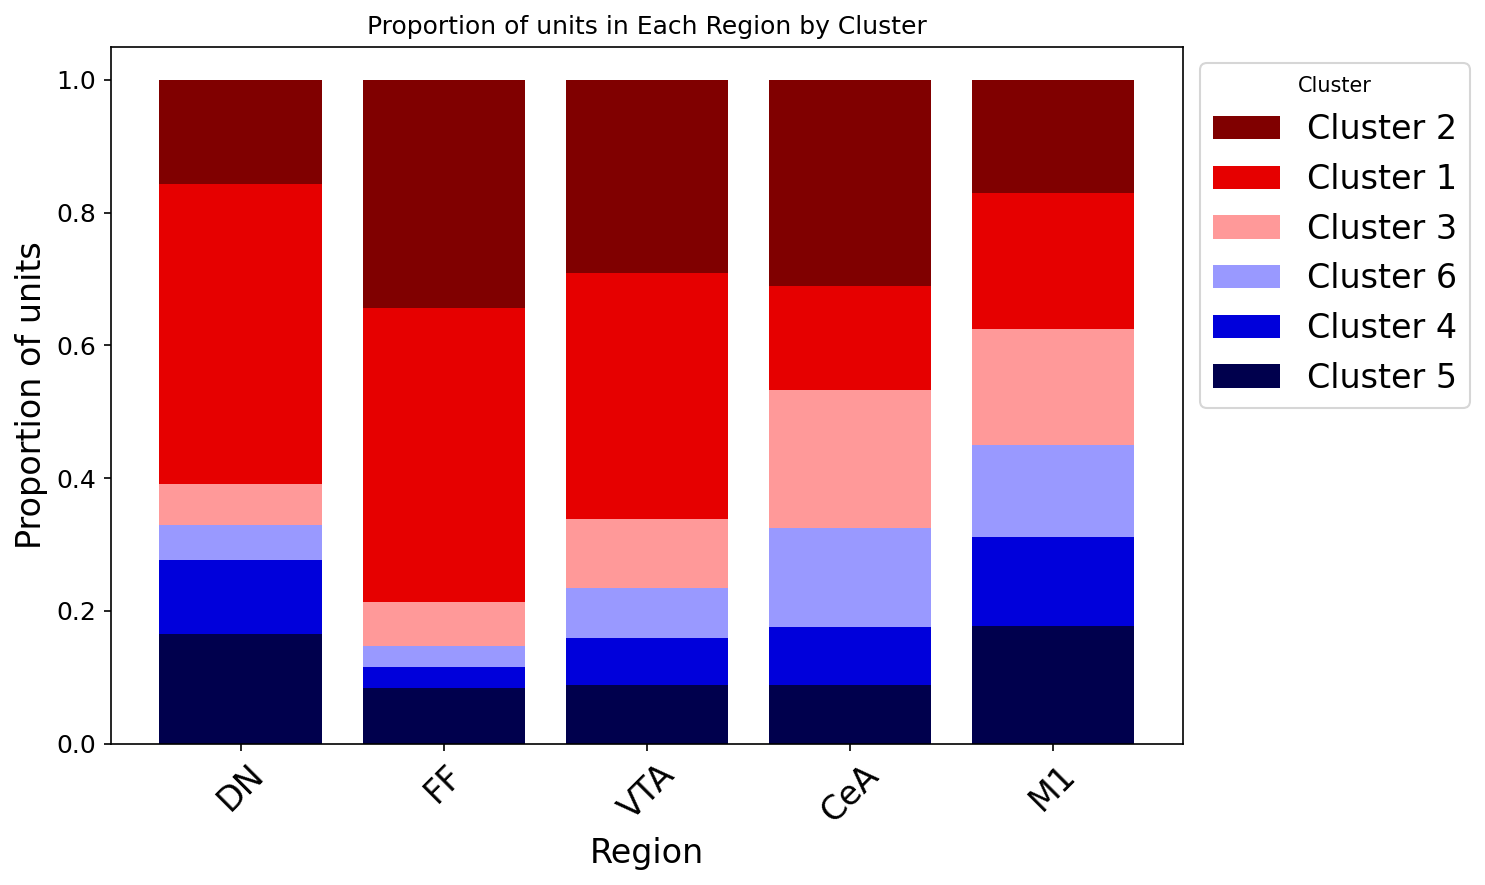

In [350]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each cluster (using Viridis colormap)
colors = plt.cm.seismic(np.linspace(0, 1, len(region_cluster_df.index)))

# Initialize bottom for stacking
bottom = np.zeros(len(region_cluster_df.columns))

# Define the desired cluster order
cluster_order = (np.array([5, 4, 6, 3, 1, 2])-1) 

# Reorder the dataframe and clusters based on cluster_order
region_cluster_df_ordered = region_cluster_df.loc[cluster_order]

# List to store bar artists and labels for the legend
bars = []
labels = []

# Plot each cluster in the specified order
for i, (cluster, color) in enumerate(zip(region_cluster_df_ordered.index, colors)):
    bars.append(
        ax.bar(
            region_cluster_df.columns, 
            region_cluster_df_ordered.loc[cluster], 
            bottom=bottom, 
            color=color
        )
    )
    labels.append(f"Cluster {cluster + 1}")  # Corresponding label

    bottom += region_cluster_df_ordered.loc[cluster]  # Update bottom for stacking

bars_reversed = bars[::-1]
labels_reversed = labels[::-1]

# Labels and formatting
ax.set_ylabel("Proportion of units")
ax.set_xlabel("Region")
ax.set_title("Proportion of units in Each Region by Cluster")

# Manually set the legend with the bars and labels in the desired order
ax.legend(bars_reversed, labels_reversed, title="Cluster", bbox_to_anchor=(1, 1))

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


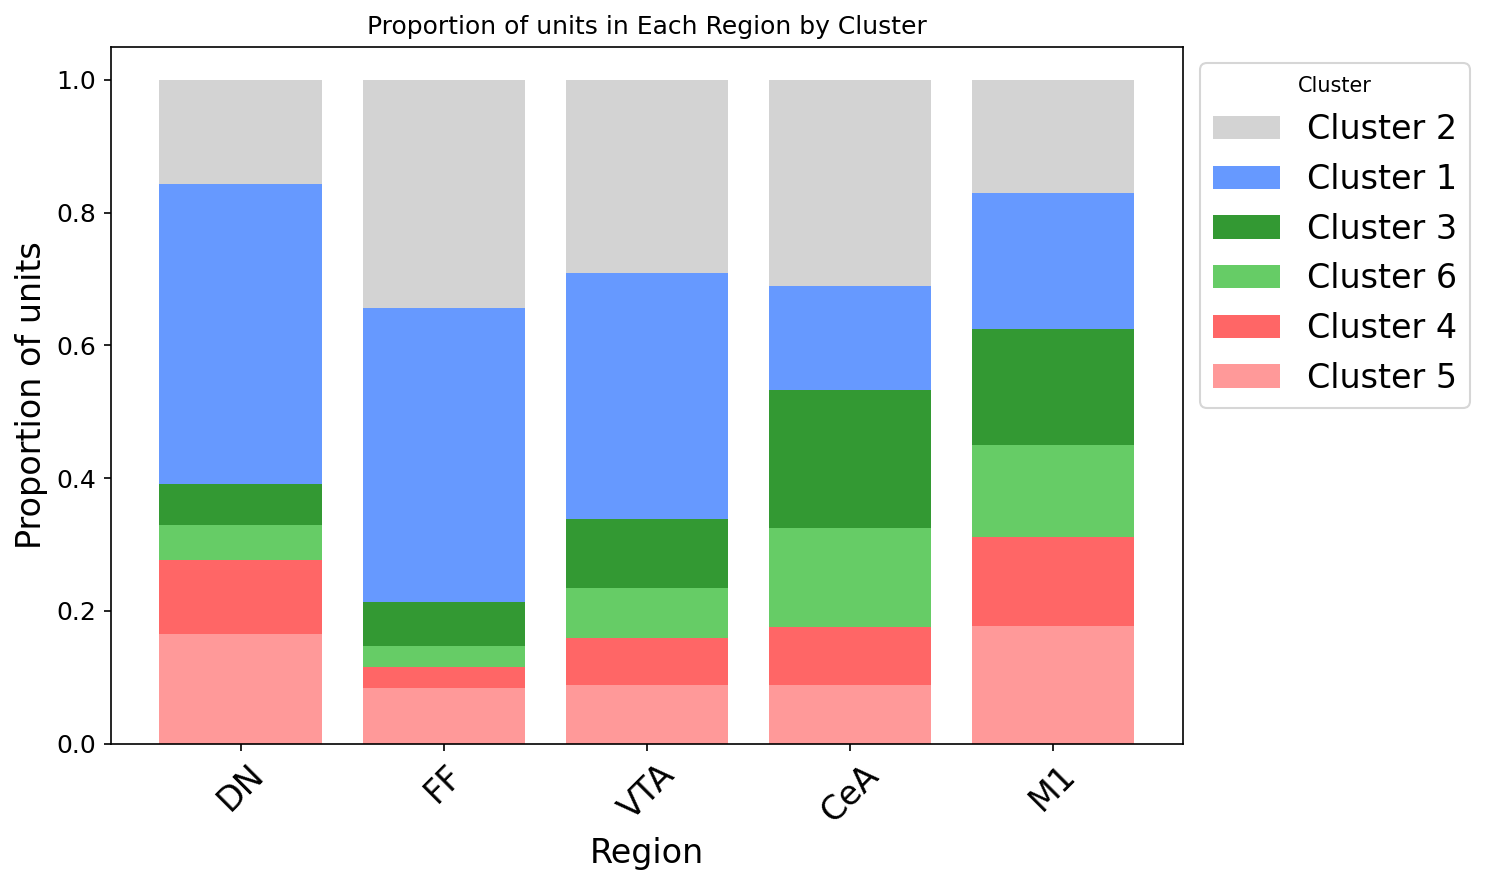

In [355]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Define a custom colormap with visually similar colors for specified clusters
custom_colors = [
    "#ff9999",  # Light Red (Cluster 5)
    "#ff6666",  # Darker Red (Cluster 4, similar to 5)
    "#66cc66",  # Light Green (Cluster 6)
    "#339933",  # Darker Green (Cluster 3, similar to 6)
    "#6699ff",  # Light Blue (Cluster 1)
    "#D3D3D3"   # Gray (Cluster 2)
]

# Initialize bottom for stacking
bottom = np.zeros(len(region_cluster_df.columns))

# Define the desired cluster order
cluster_order = (np.array([5, 4, 6, 3, 1, 2]) - 1)

# Reorder the dataframe and clusters based on cluster_order
region_cluster_df_ordered = region_cluster_df.loc[cluster_order]

# List to store bar artists and labels for the legend
bars = []
labels = []

# Plot each cluster in the specified order
for i, (cluster, color) in enumerate(zip(region_cluster_df_ordered.index, custom_colors)):
    bars.append(
        ax.bar(
            region_cluster_df.columns, 
            region_cluster_df_ordered.loc[cluster], 
            bottom=bottom, 
            color=color
        )
    )
    labels.append(f"Cluster {cluster + 1}")  # Corresponding label

    bottom += region_cluster_df_ordered.loc[cluster]  # Update bottom for stacking

bars_reversed = bars[::-1]
labels_reversed = labels[::-1]

# Labels and formatting
ax.set_ylabel("Proportion of units")
ax.set_xlabel("Region")
ax.set_title("Proportion of units in Each Region by Cluster")

# Manually set the legend with the bars and labels in the desired order
ax.legend(bars_reversed, labels_reversed, title="Cluster", bbox_to_anchor=(1, 1))

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


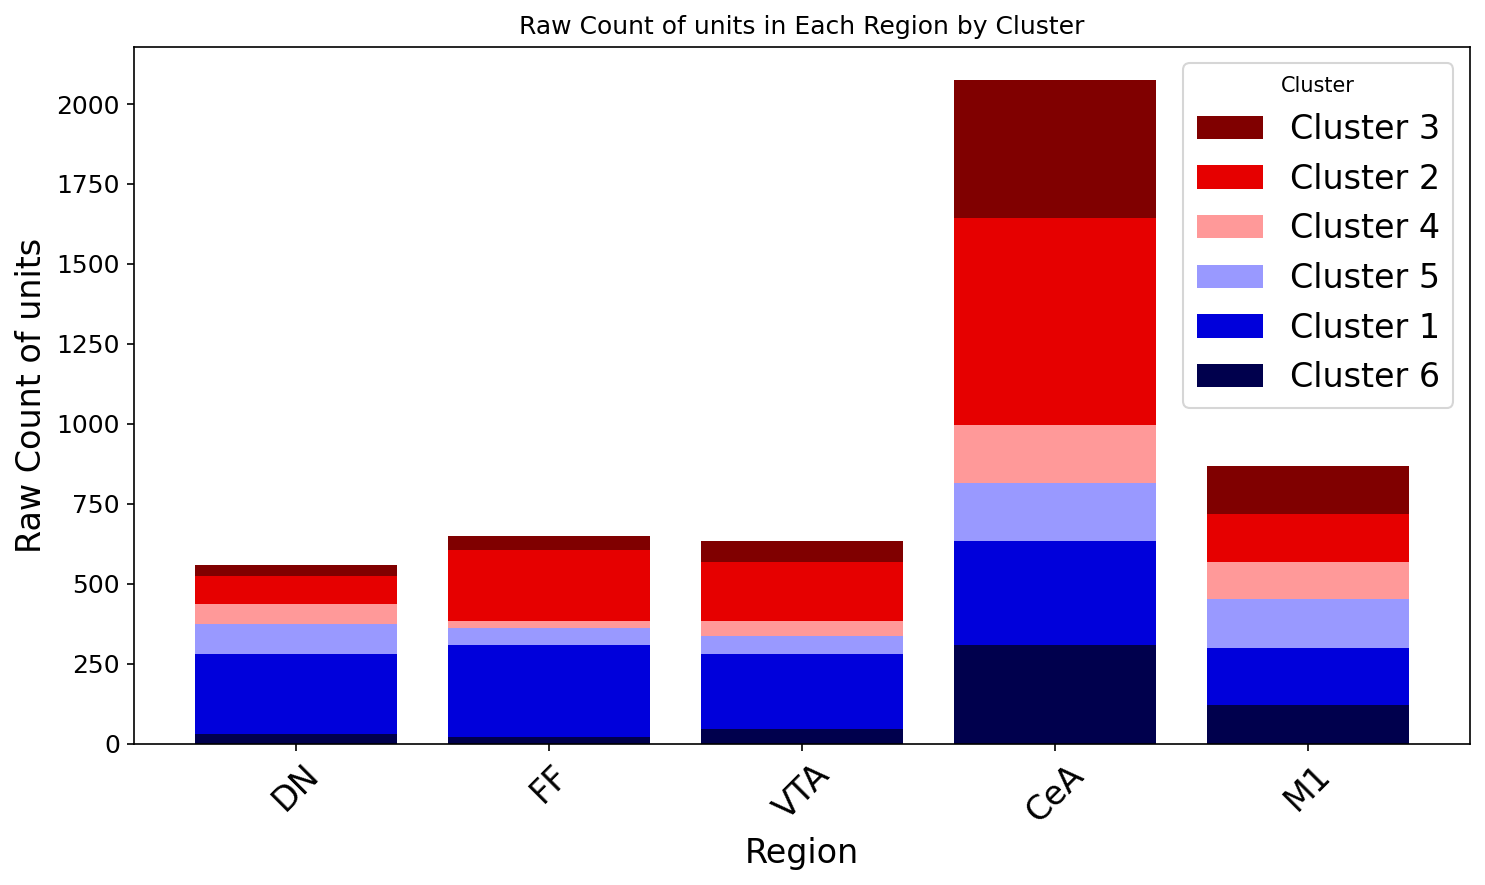

In [336]:
# Assuming `region_cluster_df` now contains the raw counts
# raw_counts_df = region_cluster_df # Replace with actual data if different

# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each cluster (using Viridis colormap)
colors = plt.cm.seismic(np.linspace(0, 1, len(region_cluster_countsdf.index)))

# Initialize bottom for stacking
bottom = np.zeros(len(region_cluster_countsdf.columns))

# List to store bar artists and labels for the legend
bars = []
labels = []

# Plot each cluster and store legend labels in the original order
for i, (cluster, color) in enumerate(zip(region_cluster_countsdf.index, colors)):
    bars.append(
        ax.bar(
            region_cluster_countsdf.columns, 
            region_cluster_countsdf.loc[cluster], 
            bottom=bottom, 
            color=color
        )
    )
    labels.append(f"Cluster {cluster + 1}")  # Corresponding label

    bottom += region_cluster_countsdf.loc[cluster]  # Update bottom for stacking

bars_reversed = bars[::-1]
labels_reversed = labels[::-1]

# Labels and formatting
ax.set_ylabel("Raw Count of units")
ax.set_xlabel("Region")
ax.set_title("Raw Count of units in Each Region by Cluster")

# Manually set the legend with the bars and labels in the desired order
ax.legend(bars_reversed, labels_reversed, title="Cluster", loc="upper right")

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


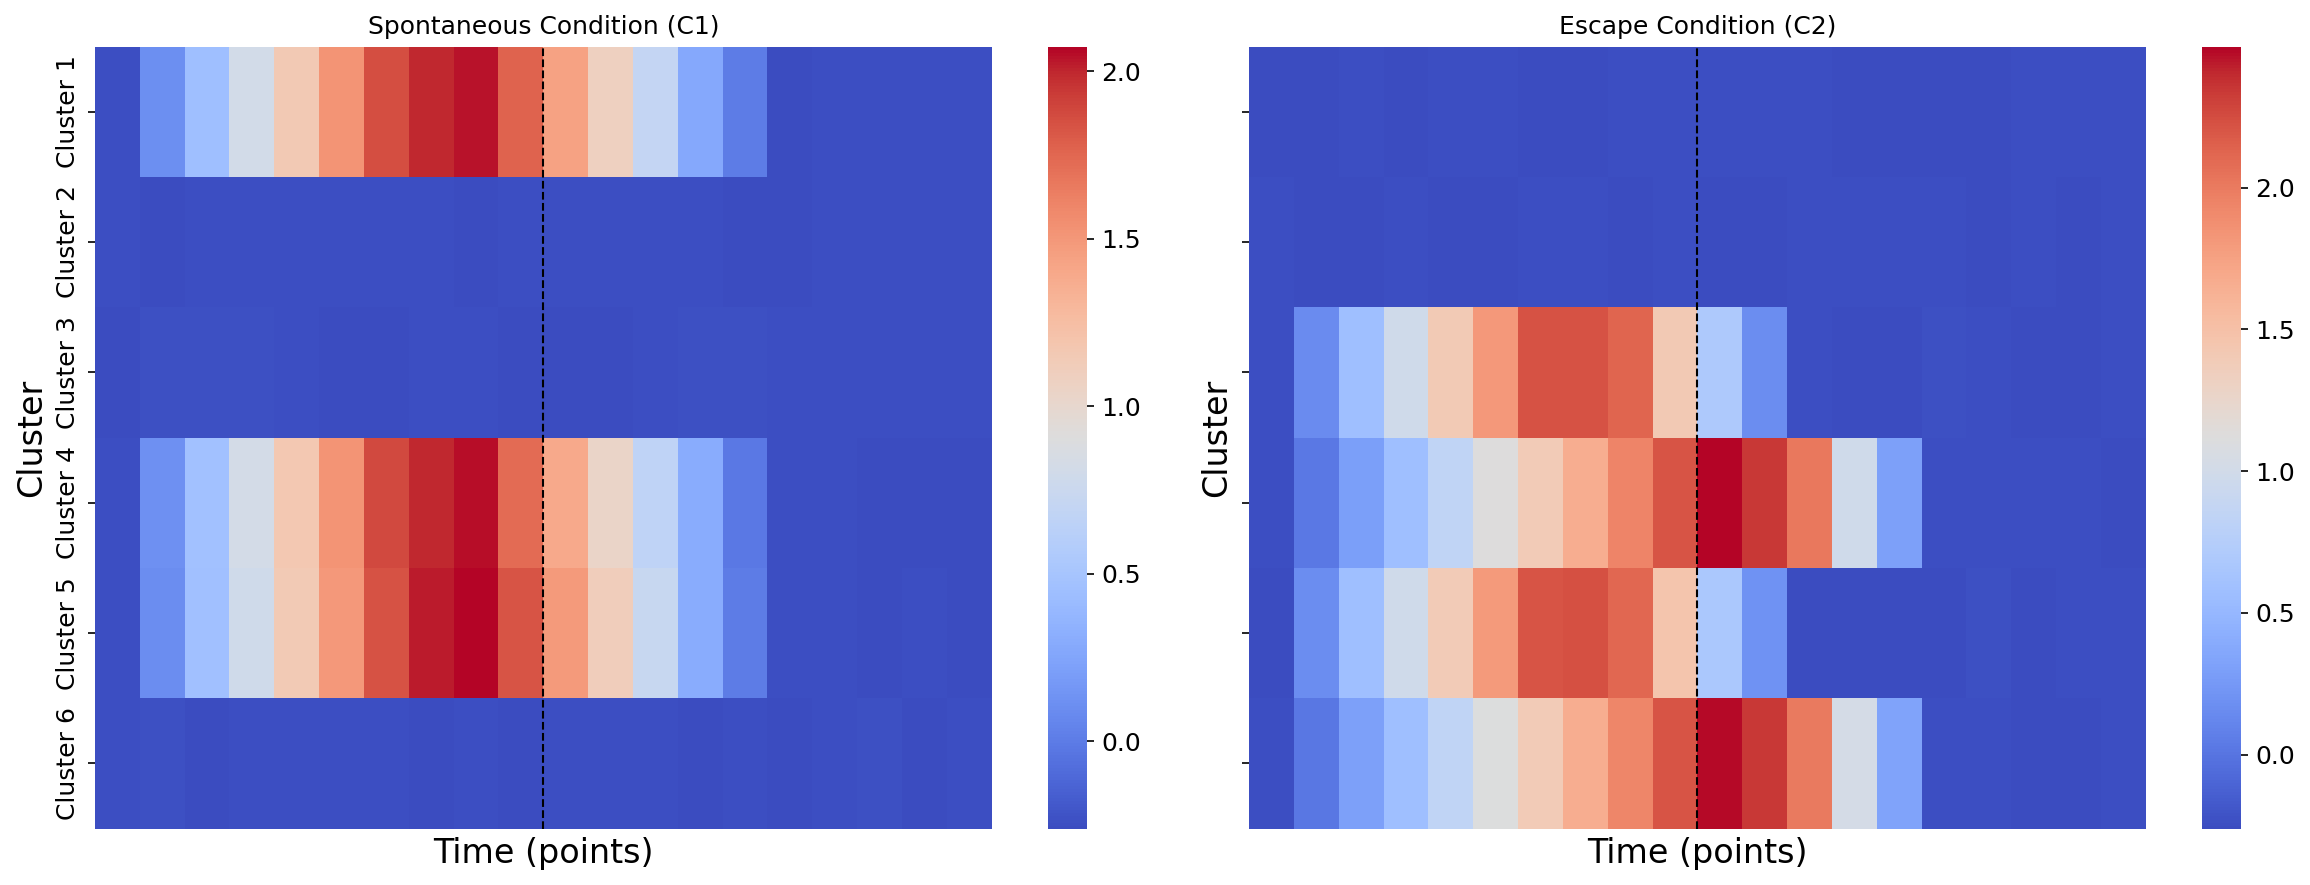

In [337]:
# Store averaged time series for each cluster in each condition
cluster_averages_C1 = []
cluster_averages_C2 = []

for cluster_id in range(num_clusters):
    # Extract units that belong to the current cluster for both conditions
    cluster_indices = [i for i, cluster in enumerate(clusters) if cluster == cluster_id]
    
    # Average time series for C1 and C2 within the current cluster
    cluster_avg_C1 = np.mean([C1_activity[i][2] for i in cluster_indices], axis=0)
    cluster_avg_C2 = np.mean([C2_activity[i][2] for i in cluster_indices], axis=0)
    
    # Append to the list of averaged time series
    cluster_averages_C1.append(cluster_avg_C1)
    cluster_averages_C2.append(cluster_avg_C2)

# Convert lists to arrays for heatmap plotting
cluster_averages_C1 = np.array(cluster_averages_C1)
cluster_averages_C2 = np.array(cluster_averages_C2)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(cluster_averages_C1, ax=axes[0], cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=[f"Cluster {i+1}" for i in range(num_clusters)])
axes[0].set_title("Spontaneous Condition (C1)")
axes[0].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)

sns.heatmap(cluster_averages_C2, ax=axes[1], cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=[f"Cluster {i+1}" for i in range(num_clusters)])
axes[1].set_title("Escape Condition (C2)")
axes[1].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)

# Set labels
for ax in axes:
    ax.set_xlabel("Time (points)")
    ax.set_ylabel("Cluster")

plt.tight_layout()
plt.show()


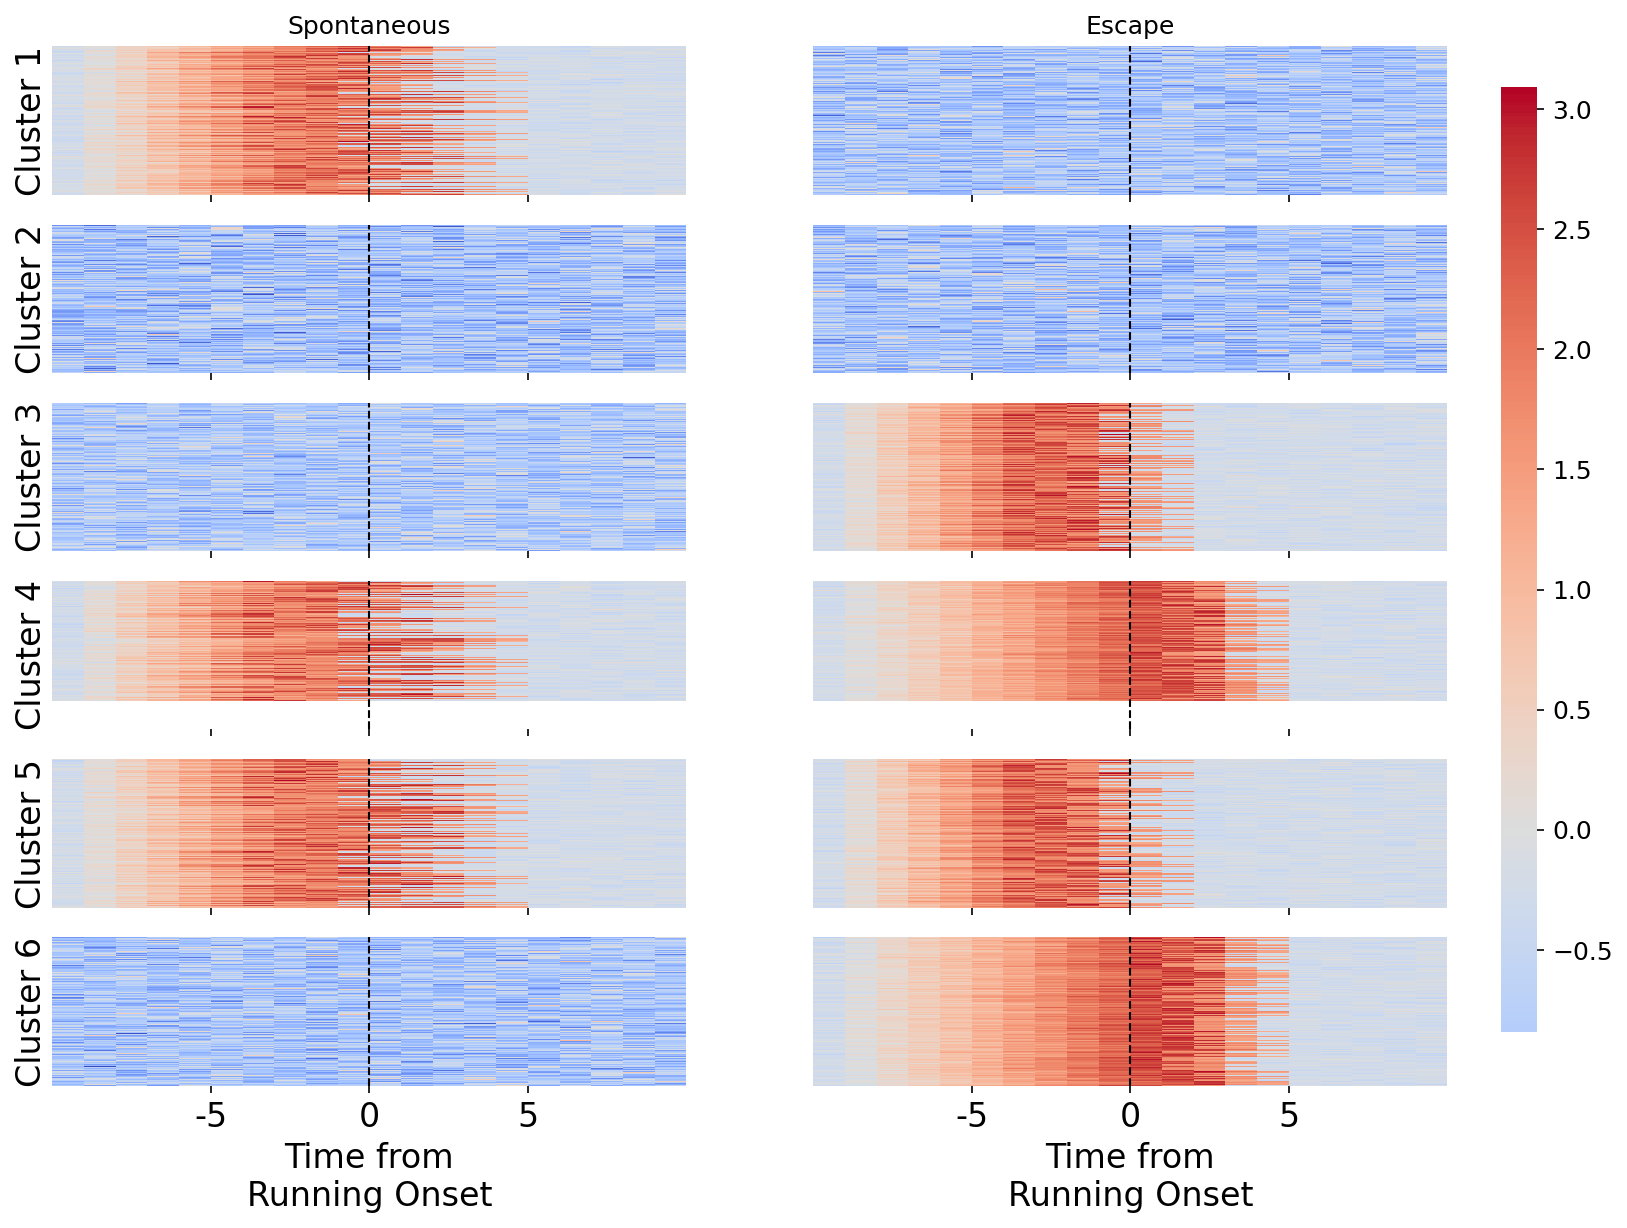

In [338]:
# Create an empty list to store the data for each cluster
cluster_units_C1 = [
    [C1_activity[i][2] for i, cluster in enumerate(clusters) if cluster == cluster_id]
    for cluster_id in range(num_clusters)
]
cluster_units_C2 = [
    [C2_activity[i][2] for i, cluster in enumerate(clusters) if cluster == cluster_id]
    for cluster_id in range(num_clusters)
]

# Convert lists to arrays
cluster_units_C1 = [np.array(cells) for cells in cluster_units_C1]
cluster_units_C2 = [np.array(cells) for cells in cluster_units_C2]

# Create the figure and axes
fig, axes = plt.subplots(num_clusters, 2, figsize=(12, 1.5 * num_clusters), sharex=True, sharey=True)

# Define the colormap for the heatmaps
cmap = "coolwarm"

# Create a colorbar axis
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust position as needed

# Loop through each cluster to plot its time series
for cluster_id in range(num_clusters):
    # For C1: Plot the individual units' time series in the current cluster
    sns.heatmap(cluster_units_C1[cluster_id], ax=axes[cluster_id, 0], cmap=cmap, cbar_ax=cbar_ax, 
                 xticklabels=False, yticklabels=False, center=0)

    # Add rotated cluster label on the y-axis for each row
    axes[cluster_id, 0].set_ylabel(f"Cluster {cluster_id + 1}", rotation=90, labelpad=10, va="center")

    # For C2: Plot the individual units' time series in the current cluster
    sns.heatmap(cluster_units_C2[cluster_id], ax=axes[cluster_id, 1], cmap=cmap, cbar_ax=cbar_ax, 
                 xticklabels=False, yticklabels=False, center=0)

    # Add vertical line for pre-stimulus time point
    axes[cluster_id, 0].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    axes[cluster_id, 1].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)

# Set column titles for conditions
axes[0, 0].set_title("Spontaneous")
axes[0, 1].set_title("Escape")

# Set overall labels for x and y axes
for ax in axes[-1, :]:  # Set x-axis label on the bottom row
    ax.set_xlabel("Time from\nRunning Onset")
    ax.set_xticks([5, 10,15],labels = [-5,0,5])


#plt.tight_layout()
plt.show()

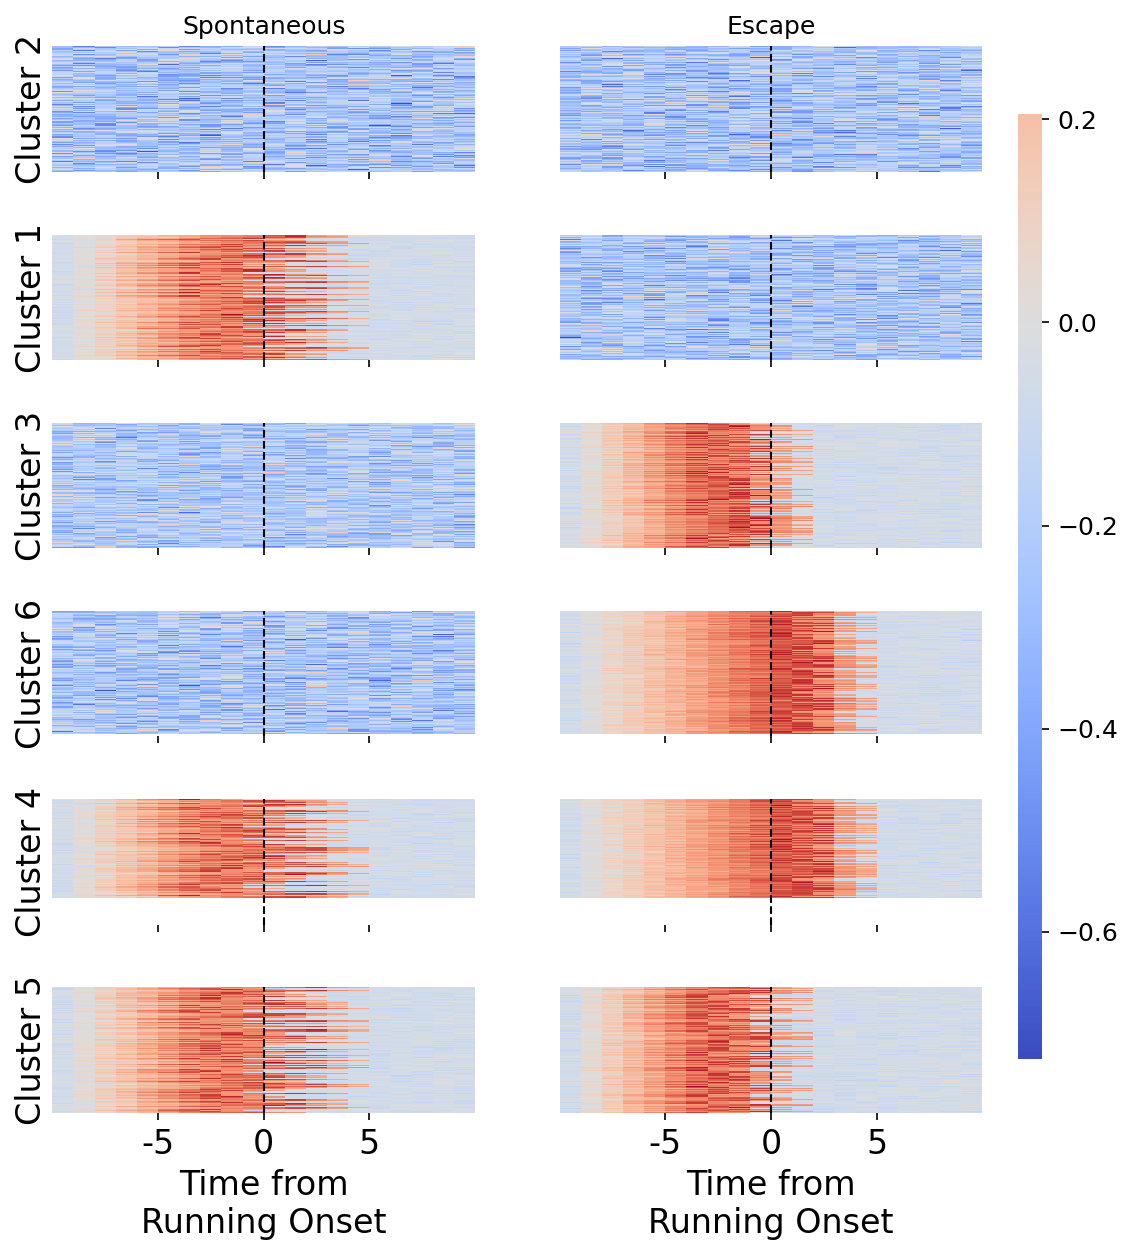

In [344]:
# Create lists to store time series for each cluster in C1 and C2
cluster_units_C1 = [
    [C1_activity[i][2] for i, cluster in enumerate(clusters) if cluster == cluster_id]
    for cluster_id in range(num_clusters)
]
cluster_units_C2 = [
    [C2_activity[i][2] for i, cluster in enumerate(clusters) if cluster == cluster_id]
    for cluster_id in range(num_clusters)
]

# Define the desired cluster order
cluster_order = [2, 1, 3, 6, 4, 5]  # Adjusted order based on 1-indexed clusters

# Convert lists to arrays for heatmap plotting
cluster_units_C1 = [np.array(cells) for cells in cluster_units_C1]
cluster_units_C2 = [np.array(cells) for cells in cluster_units_C2]

# Create the figure and axes for subplots
fig, axes = plt.subplots(len(cluster_order), 2, figsize=(8, 1.5 * len(cluster_order)), sharex=True, sharey=True)

# Define colormap for heatmaps
cmap = "coolwarm"

# Create a colorbar axis
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust position as needed

# Plot the heatmaps for each cluster in the specified order
for plot_idx, cluster_id in enumerate(cluster_order):
    cluster_idx = cluster_id - 1  # Adjust for zero-indexing

    # For C1: Plot the individual units' time series for the current cluster
    sns.heatmap(cluster_units_C1[cluster_idx], ax=axes[plot_idx, 0], cmap=cmap, cbar=(plot_idx == 0), 
                cbar_ax=cbar_ax if plot_idx == 0 else None, xticklabels=False, yticklabels=False, center=0)

    # Add rotated cluster label on the y-axis for each row
    axes[plot_idx, 0].set_ylabel(f"Cluster {cluster_id}", rotation=90, labelpad=10, va="center")

    # For C2: Plot the individual units' time series for the current cluster
    sns.heatmap(cluster_units_C2[cluster_idx], ax=axes[plot_idx, 1], cmap=cmap, cbar=False, 
                xticklabels=False, yticklabels=False, center=0)

    # Add vertical line for pre-stimulus time point
    axes[plot_idx, 0].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    axes[plot_idx, 1].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)

# Set column titles for conditions
axes[0, 0].set_title("Spontaneous")
axes[0, 1].set_title("Escape")

# Set x-axis labels on the bottom row
for ax in axes[-1, :]:
    ax.set_xlabel("Time from\nRunning Onset")
    ax.set_xticks([5, 10, 15])
    ax.set_xticklabels([-5, 0, 5])

# Display the plot
plt.subplots_adjust(top=0.9, hspace=0.5)

plt.show()


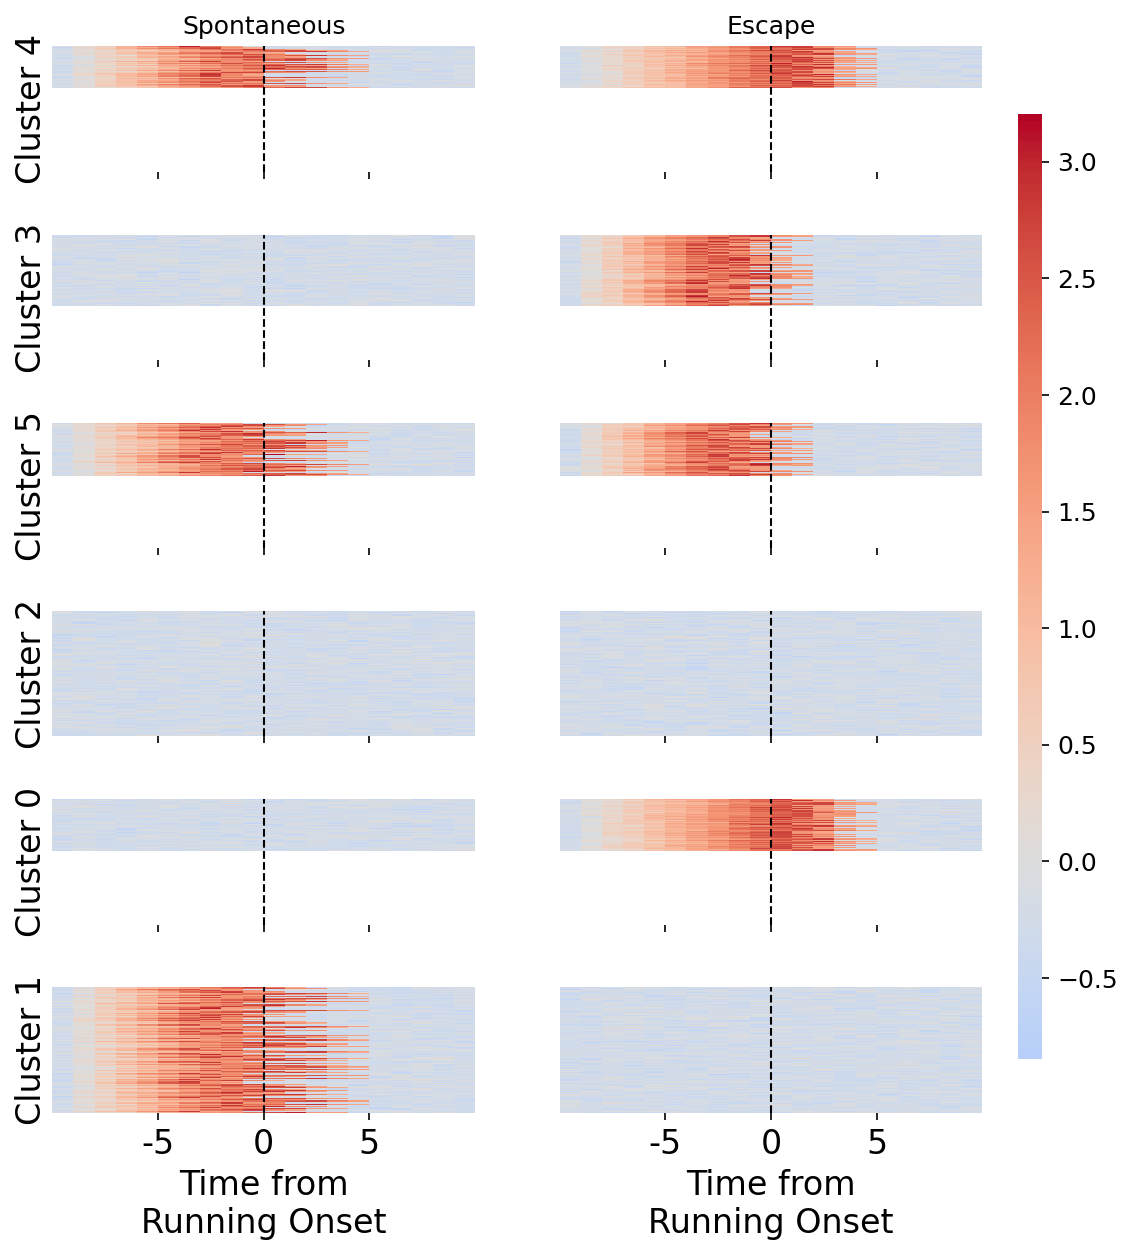

In [351]:

# Calculate global vmin and vmax for consistent color scaling
vmin = min(
    np.min(cluster_units_C1[cluster_idx]) 
    for cluster_idx in range(num_clusters)
)
vmax = max(
    np.max(cluster_units_C1[cluster_idx]) 
    for cluster_idx in range(num_clusters)
)

# Include both C1 and C2 ranges
vmin = min(vmin, min(np.min(cluster_units_C2[cluster_idx]) for cluster_idx in range(num_clusters)))
vmax = max(vmax, max(np.max(cluster_units_C2[cluster_idx]) for cluster_idx in range(num_clusters)))

# Create the figure and axes for subplots
fig, axes = plt.subplots(len(cluster_order), 2, figsize=(8, 1.5 * len(cluster_order)), sharex=True, sharey=True)

# Define colormap for heatmaps
cmap = "coolwarm"

# Create a colorbar axis
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust position as needed

# Plot the heatmaps for each cluster in the specified order
for plot_idx, cluster_id in enumerate(cluster_order):
    cluster_idx = cluster_id - 1  # Adjust for zero-indexing

    # For C1: Plot the individual units' time series for the current cluster
    sns.heatmap(
        cluster_units_C1[cluster_idx], 
        ax=axes[plot_idx, 0], 
        cmap=cmap, 
        cbar=(plot_idx == 0), 
        cbar_ax=cbar_ax if plot_idx == 0 else None, 
        xticklabels=False, 
        yticklabels=False, 
        center=0, 
        vmin=vmin, 
        vmax=vmax
    )

    # Add rotated cluster label on the y-axis for each row
    axes[plot_idx, 0].set_ylabel(f"Cluster {cluster_id}", rotation=90, labelpad=10, va="center")

    # For C2: Plot the individual units' time series for the current cluster
    sns.heatmap(
        cluster_units_C2[cluster_idx], 
        ax=axes[plot_idx, 1], 
        cmap=cmap, 
        cbar=False, 
        xticklabels=False, 
        yticklabels=False, 
        center=0, 
        vmin=vmin, 
        vmax=vmax
    )

    # Add vertical line for pre-stimulus time point
    axes[plot_idx, 0].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    axes[plot_idx, 1].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    # Set column titles for conditions

axes[0, 0].set_title("Spontaneous")
axes[0, 1].set_title("Escape")

# Set x-axis labels on the bottom row
for ax in axes[-1, :]:
    ax.set_xlabel("Time from\nRunning Onset")
    ax.set_xticks([5, 10, 15])
    ax.set_xticklabels([-5, 0, 5])

# Display the plot
plt.subplots_adjust(top=0.9, hspace=0.5)

plt.show()